In [1]:
import os
import csv
import math
import joblib
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter, OrderedDict, defaultdict
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image 

pd.set_option('display.max_columns', None)

# Funções de Apoio

In [2]:
import sys
sys.path.append('../../TCC/evolutionary-computation/instances/weka/')

In [3]:
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

In [4]:
def pieChart(values, labels, legendTitle, title, colors=None):
    fig0, ax0 = plt.subplots(figsize=(6,6), subplot_kw=dict(aspect="equal"))

    def func(pct, allvals):
        absolute = int(round_up(pct/100.*np.sum(allvals), 1))
        return "{:.1f}% ({:d})".format(pct, absolute)

    wedges, texts, autotexts = ax0.pie(values, 
                                      autopct=lambda pct: func(pct, values),
                                      textprops=dict(color="w"), colors=colors)

    # Decoration
    ax0.legend(wedges, labels, title=legendTitle, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight="bold")
    ax0.set_title(title)
    plt.show()

# Used files

In [73]:
LOM_to_csv_file = "LOM_to_csv.csv"
studentXselectedMaterials_file = '../andre/evolutionary-computation/studentXselectedMaterials-02-06-2020.csv'
material_coverage_file = '../evolutionary-computation/instances/real/material_coverage.csv'
learners_test_file = "../evolutionary-computation/instances/real/learners_test.csv"
materials_keys_file = "/home/bravo/Documentos/TCC/andre/evolutionary-computation/instance.materials_keys-05-06-2020.csv"

# Base Real de Materiais

In [6]:
from enums import InteractivityType
from enums import LearningResourceType
from enums import InteractivityLevel
from enums import Difficulty
from enums import Format

In [7]:

lom_df = pd.read_csv(LOM_to_csv_file)

lom_df.head()

,identifier,title,keyword0,keyword1,keyword2,keyword3,keyword4,keyword5,keyword6,keyword7,keyword8,keyword9,keyword10,keyword11,keyword12,keyword13,keyword14,keyword15,keyword16,keyword17,keyword18,keyword19,keyword20,keyword21,keyword22,keyword23,keyword24,keyword25,keyword26,keyword27,keyword28,keyword29,keyword30,keyword31,keyword32,keyword33,keyword34,keyword35,keyword36,keyword37,keyword38,format,size,interactivityType,learningResourceType0,learningResourceType1,learningResourceType2,learningResourceType3,learningResourceType4,learningResourceType5,learningResourceType6,learningResourceType7,interactivityLevel,difficulty,typicalLearningTime
0,255,Noções de Sistema Operacional,sistema operacional,sistema operacionais,so,funções do sistema operacional,característica do so,definição,tipos de so,classificação,gerenciador,gerenciador de recursos,gerenciador de processos,gerenciador de memória,gerenciador de E/S,processo,memória,entrada e saída,sistema,monoprogramado,monotarefa,monousuário,multiprogramado,multiusuário,multitarefa,lote,bach,tempo compartilhado,tempo real,multiprocessado,embarcado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Format.APPLICATION_PDF,3.116660e+05,InteractivityType.MIXED,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.TABLE,LearningResourceType.QUESTIONNAIRE,LearningResourceType.DIAGRAM,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.VERY_EASY,00:15:17
1,269,O Sistema Operacional,sistema operacional,so,os,funções do so,funções,característica do so,definição,gerenciador,gerenciador de recursos,gerenciador de processos,gerenciador de memória,gerenciador de E/S,processo,memória,entrada e saída,sistema,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Format.IMAGE_PNG,3.953680e+05,InteractivityType.EXPOSITIVE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,NaN,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.VERY_EASY,00:06:00
2,279,Componentes e Arquitetura,sistema operacional,so,os,memória,entrada e saída,sistema,hardware,cpu,processador,ula,uc,registradores,barramento,ram,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Format.APPLICATION_PDF,4.751680e+05,InteractivityType.EXPOSITIVE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,LearningResourceType.TABLE,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.VERY_EASY,00:19:06
3,262,Tipos de Sistemas operacionais,sistema operacional,so,os,tipos de so,classificação,monoprogramado,monotarefa,monousuário,multiprogramado,multiusuário,multitarefa,lote,bach,tempo compartilhado,tempo real,multiprocessado,hardware,cpu,processador,sistema,gerenciador,gerenciador de recursos,gerenciador de processo,gerenciador de memória,gerenciador de entrada e saída,entrada e saída,processo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Format.VIDEO_MP4,1.077844e+09,InteractivityType.EXPOSITIVE,LearningResourceType.SLIDE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.MEDIUM,00:44:17
4,278,Partes que compõem o computador,sistema operacional,so,os,memória,entrada e saída,sistema,hardware,cpu,processador,ula,uc,registradores,barramento,ram,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Format.APPLICATION_PDF,2.449303e+06,InteractivityType.EXPOSITIVE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,LearningResourceType.TABLE,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.MEDIUM,00:17:48


Algumas características não são tão importantes no momento e além disso possuem muitos dados faltantes(NaN). Portanto iremos descartá-las: <b>title</b>, <b>keywords</b>[0..38].

In [8]:
lom_df = lom_df.drop(columns=['title'] + ['keyword'+str(i) for i in range(39)])
lom_df.head()

,identifier,format,size,interactivityType,learningResourceType0,learningResourceType1,learningResourceType2,learningResourceType3,learningResourceType4,learningResourceType5,learningResourceType6,learningResourceType7,interactivityLevel,difficulty,typicalLearningTime
0,255,Format.APPLICATION_PDF,3.116660e+05,InteractivityType.MIXED,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.TABLE,LearningResourceType.QUESTIONNAIRE,LearningResourceType.DIAGRAM,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.VERY_EASY,00:15:17
1,269,Format.IMAGE_PNG,3.953680e+05,InteractivityType.EXPOSITIVE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,NaN,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.VERY_EASY,00:06:00
2,279,Format.APPLICATION_PDF,4.751680e+05,InteractivityType.EXPOSITIVE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,LearningResourceType.TABLE,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.VERY_EASY,00:19:06
3,262,Format.VIDEO_MP4,1.077844e+09,InteractivityType.EXPOSITIVE,LearningResourceType.SLIDE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.MEDIUM,00:44:17
4,278,Format.APPLICATION_PDF,2.449303e+06,InteractivityType.EXPOSITIVE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.FIGURE,LearningResourceType.DIAGRAM,LearningResourceType.TABLE,NaN,NaN,NaN,NaN,InteractivityLevel.VERY_LOW,Difficulty.MEDIUM,00:17:48


Analisar: format, size, interactvityType, interactivityLevel, difficulty, typicalLearningTime, learningResourceType <br>
Frequência, Média, Mediana de cada categoria em cada coluna
    

### Format 

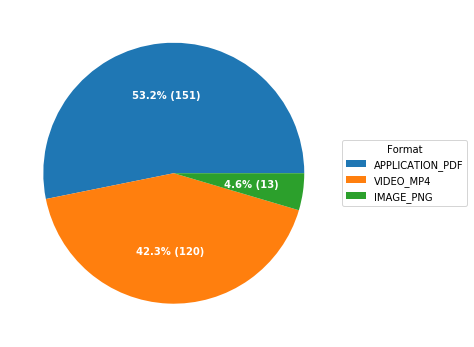

In [9]:
# format
formatCol = lom_df[['format']]


labels=['APPLICATION_PDF', 'VIDEO_MP4', 'IMAGE_PNG']
values = formatCol['format'].value_counts()

pieChart(values, labels, legendTitle = "Format", title="")

### Interactvity Type

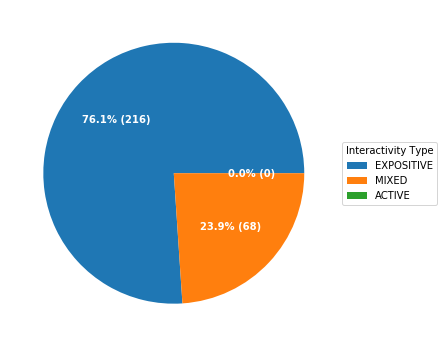

In [10]:
# interactivityType

interactivityTypeCol = lom_df[['interactivityType']]

labels = ['EXPOSITIVE', 'MIXED', 'ACTIVE']
values = interactivityTypeCol['interactivityType'].value_counts().append(pd.Series({'InteractivityType.ACTIVE': 0}))

pieChart(values, labels, legendTitle = "Interactivity Type", title="")

### Interactivity Level

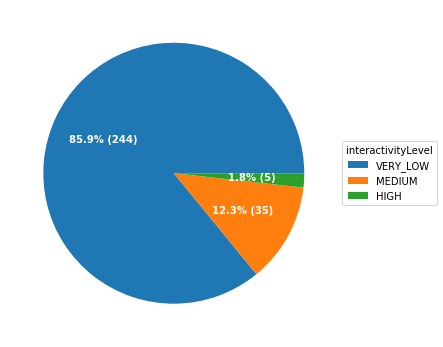

In [11]:
interactivityLevelCol = lom_df[['interactivityLevel']]

labels = ['VERY_LOW', 'MEDIUM', 'HIGH']
values = interactivityLevelCol['interactivityLevel'].value_counts()

pieChart(values, labels, legendTitle = "interactivityLevel", title="")

### Difficulty

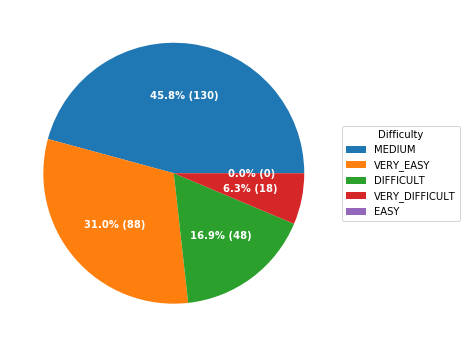

In [12]:
difficultyCol = lom_df[['difficulty']]

labels = ['MEDIUM', 'VERY_EASY', 'DIFFICULT', 'VERY_DIFFICULT', 'EASY']
values = difficultyCol['difficulty'].value_counts().append(pd.Series({'Difficulty.EASY': 0}))
#values
pieChart(values, labels, legendTitle = "Difficulty", title="")

###  Learning Resource Type

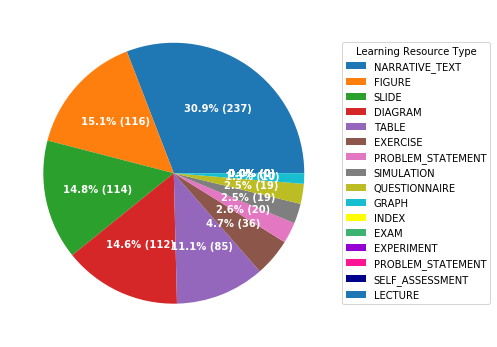

In [13]:
learningResourceTypeCol = lom_df[['learningResourceType'+str(i) for i in range(8)]]
learningResourceTypeCol.apply(pd.value_counts).fillna(0)
learningResourceTypeCol.stack().value_counts()

labels= ['NARRATIVE_TEXT', 'FIGURE', 'SLIDE', 'DIAGRAM', 'TABLE', 'EXERCISE', 'PROBLEM_STATEMENT', 'SIMULATION', 'QUESTIONNAIRE', 'GRAPH', 'INDEX', 'EXAM', 'EXPERIMENT', 'PROBLEM_STATEMENT', 'SELF_ASSESSMENT', 'LECTURE']
values = learningResourceTypeCol.stack().value_counts().append(pd.Series({'INDEX': 0, 'EXAM': 0, 'EXPERIMENT': 0, 'PROBLEM_STATEMENT': 0, 'SELF_ASSESSMENT': 0, 'LECTURE': 0}))
#values

colors=['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#FFFF00', '#3CB371', '#9400D3', '#FF1493', '#00008B']

pieChart(values, labels, legendTitle = "Learning Resource Type", title="", colors=colors)

### Typical Learning Time

In [14]:
typicalLearningTimeCol = lom_df[['typicalLearningTime']].applymap(lambda time_str: datetime.datetime.strptime(time_str, '%H:%M:%S').time())

maxTime = datetime.time(0,0,0)
minTime = typicalLearningTimeCol.iloc[0,0]


for time in typicalLearningTimeCol.typicalLearningTime:
    if(time > maxTime):
        maxTime = time
    if(time < minTime):
        minTime = time

print(maxTime)
print(minTime)

13:02:57
00:01:30


In [15]:
listTime = sorted(typicalLearningTimeCol.typicalLearningTime.to_list())

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

dts = [(datetime.datetime.min + dt).time() for dt in datetime_range(datetime.timedelta(minutes=5), datetime.timedelta(hours=3, minutes=5), datetime.timedelta(minutes=5))]

timeL = [minTime] + dts + [datetime.time(3, 15), datetime.time(5, 25), datetime.time(6, 15), datetime.time(13, 5) ]

timeDict = {}
for i, time in enumerate(timeL[:-1]):
    timeDict.update({str(timeL[i]) + " - " + str(timeL[i+1]): 0})

    
for duration in listTime:
    for i, time in enumerate(timeL[:-1]):
        if(duration >= timeL[i] and duration <  timeL[i+1]):
            timeDict[str(timeL[i]) + " - " + str(timeL[i+1])] += 1


print(timeDict)
print(sum(timeDict.values()))

{'00:01:30 - 00:05:00': 30, '00:05:00 - 00:10:00': 59, '00:10:00 - 00:15:00': 35, '00:15:00 - 00:20:00': 30, '00:20:00 - 00:25:00': 22, '00:25:00 - 00:30:00': 19, '00:30:00 - 00:35:00': 18, '00:35:00 - 00:40:00': 13, '00:40:00 - 00:45:00': 11, '00:45:00 - 00:50:00': 5, '00:50:00 - 00:55:00': 6, '00:55:00 - 01:00:00': 5, '01:00:00 - 01:05:00': 7, '01:05:00 - 01:10:00': 2, '01:10:00 - 01:15:00': 2, '01:15:00 - 01:20:00': 4, '01:20:00 - 01:25:00': 1, '01:25:00 - 01:30:00': 2, '01:30:00 - 01:35:00': 0, '01:35:00 - 01:40:00': 0, '01:40:00 - 01:45:00': 1, '01:45:00 - 01:50:00': 0, '01:50:00 - 01:55:00': 0, '01:55:00 - 02:00:00': 1, '02:00:00 - 02:05:00': 0, '02:05:00 - 02:10:00': 1, '02:10:00 - 02:15:00': 0, '02:15:00 - 02:20:00': 0, '02:20:00 - 02:25:00': 0, '02:25:00 - 02:30:00': 0, '02:30:00 - 02:35:00': 1, '02:35:00 - 02:40:00': 1, '02:40:00 - 02:45:00': 0, '02:45:00 - 02:50:00': 0, '02:50:00 - 02:55:00': 3, '02:55:00 - 03:00:00': 1, '03:00:00 - 03:15:00': 1, '03:15:00 - 05:25:00': 1, '0

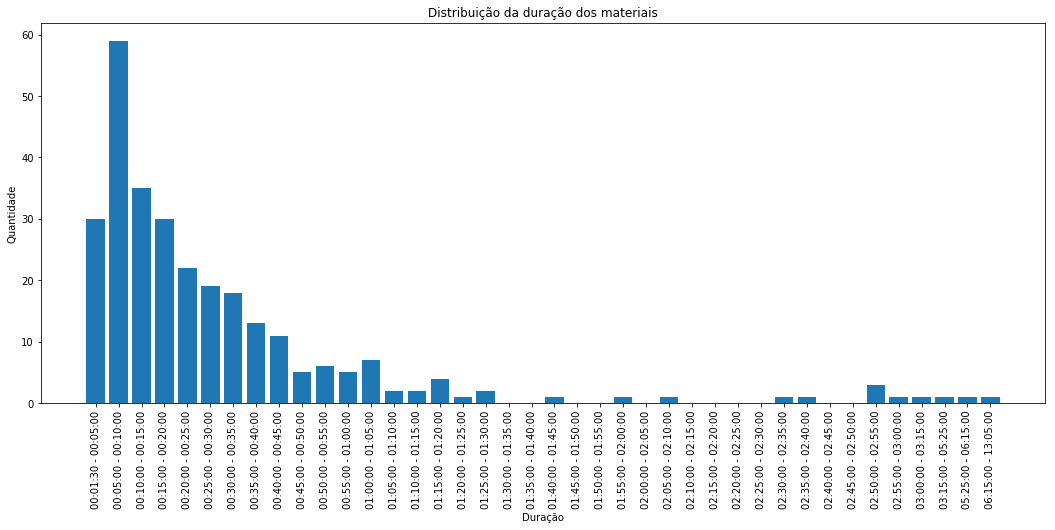

In [16]:
f, ax = plt.subplots(figsize=(18,7))
plt.bar(list(timeDict.keys()), timeDict.values())
plt.xticks(rotation=90)
ax.set_title("Distribuição da duração dos materiais")
plt.xlabel("Duração")
plt.ylabel("Quantidade")
plt.show()

### Quais são os perfis de alunos que a base atende melhor?  

O objetivo aqui é calcular para cada material qual o estilo de aprendizagem ele corresponde dada cada uma das quatro dimensões definidas por FSLSM. Para isso, será utilizada a seguinte tabela definida por MÉNDEZ et al., 2016 e modificado por MACHADO, 2018:

<sup><sup>MÉNDEZ, Nestor D. Duque; MORALES, Valentina Tabares; VICARI, Rosa M. Learning object metadata mapping with learning styles as a strategy for improving usability of educational resource repositories. IEEE Revista Iberoamericana de Tecnologias del Aprendizaje, v. 11, n. 2, p. 101-106, 2016.</sup></sup> <br>
<sup><sup>M. de O. C. Machado, “Geração de Sequências Curriculares Adaptativas baseada no Perfil dos Alunos e Materiais Didáticos utilizando o Algoritmo Presa-Predador” Universidade Federal de Juiz de Fora, 2018.</sup></sup>

In [17]:
learningStyles = ['active', 'reflective', 'sensory', 'intuitive', 'visual', 'verbal', 'sequential', 'global']

labels= ['NARRATIVE_TEXT', 'FIGURE', 'SLIDE', 'DIAGRAM', 'TABLE', 'EXERCISE', 'PROBLEM_STATEMENT', 'SIMULATION', 'QUESTIONNAIRE', 'GRAPH', 'INDEX', 'EXAM', 'EXPERIMENT', 'PROBLEM_STATEMENT', 'SELF_ASSESSMENT', 'LECTURE']

learningResourceTypeIndex = [LearningResourceType.EXERCISE, LearningResourceType.SIMULATION, LearningResourceType.QUESTIONNAIRE, LearningResourceType.DIAGRAM, LearningResourceType.FIGURE, LearningResourceType.GRAPH, LearningResourceType.SLIDE, LearningResourceType.TABLE, LearningResourceType.NARRATIVE_TEXT, LearningResourceType.EXAM, LearningResourceType.EXPERIMENT, LearningResourceType.PROBLEM_STATEMENT, LearningResourceType.SELF_ASSESSMENT, LearningResourceType.LECTURE, InteractivityLevel.VERY_LOW, InteractivityLevel.LOW, InteractivityLevel.MEDIUM, InteractivityLevel.HIGH, InteractivityLevel.VERY_HIGH, InteractivityType.ACTIVE, InteractivityType.EXPOSITIVE, InteractivityType.MIXED]

tab0 = pd.DataFrame(np.array([[1,0,1,0,0,0,1,0], [1,1,1,1,1,0,1,0], [1,0,0,1,0,0,0,0], [0,1,0,1,1,0,1,1], [0,1,0,1,1,0,0,1], [0,1,1,0,1,0,0,1], [0,1,1,1,1,1,1,1], [0,1,1,0,1,0,0,1], [0,1,1,1,0,1,1,1], [1,1,1,1,0,0,0,0], [1,0,1,0,0,0,1,0], [0,1,1,0,0,0,0,0], [1,1,1,1,1,1,1,1], [0,1,1,1,0,1,1,1], [0,0,0,0,0,0,0,0], [1,0,0,0,0,0,0,0], [2,0,0,0,0,0,0,0], [3,0,0,0,0,0,0,0], [4,0,0,0,0,0,0,0], [1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [1,1,0,0,0,0,0,0]]), columns=learningStyles)
tab0.index = learningResourceTypeIndex
tab0

,active,reflective,sensory,intuitive,visual,verbal,sequential,global
LearningResourceType.EXERCISE,1,0,1,0,0,0,1,0
LearningResourceType.SIMULATION,1,1,1,1,1,0,1,0
LearningResourceType.QUESTIONNAIRE,1,0,0,1,0,0,0,0
LearningResourceType.DIAGRAM,0,1,0,1,1,0,1,1
LearningResourceType.FIGURE,0,1,0,1,1,0,0,1
LearningResourceType.GRAPH,0,1,1,0,1,0,0,1
LearningResourceType.SLIDE,0,1,1,1,1,1,1,1
LearningResourceType.TABLE,0,1,1,0,1,0,0,1
LearningResourceType.NARRATIVE_TEXT,0,1,1,1,0,1,1,1
LearningResourceType.EXAM,1,1,1,1,0,0,0,0


Aqui cada material terá uma lista de tamanho oito com o somatório dos seus EA.

In [18]:
tab1 = lom_df[['identifier','interactivityType', 'interactivityLevel']+ ['learningResourceType'+str(i) for i in range(8)]]
tab1 = tab1.set_index('identifier')

materialStylesPointsList = list()

for index, row in tab1.iterrows(): 
    styles = np.array([0,0,0,0,0,0,0,0])
    for elem in row:
        if not(pd.isna(elem)):
            styles += np.array(tab0.loc[[eval(elem)]].values.tolist()[0]) # ex.:  LearningResourceType.LECTURE -> [0,1,1,1,0,1,1,1] + styles
    
    materialStylesPointsList.append({index: styles.tolist()})
    


Agora será calculado a tendência de cada material para cada uma das opções das dimensões de FSLSM. Esses valores podem ser positivos, negativos ou zero, indicando que não há uma tendência para nenhuma das duas opções.

In [19]:
materialStyles = list()

for material in materialStylesPointsList:
    styles = list()
    for i, style in enumerate(list(material.values())[0][:-4]):
        i *= 2 
        value = list(material.values())[0][i] - list(material.values())[0][i+1]
        if(value > 0):
            styles.append(learningStyles[i])
        elif(value < 0):
            styles.append(learningStyles[i+1])
        else:
            styles.append("neutral_"+str(i))
    materialStyles.append({list(material.keys())[0]: styles})
    
    
sty = [list(dici.values())[0] for dici in materialStyles]
stylesDict = dict(Counter(x for xs in sty for x in set(xs)))

processing = {'active': stylesDict['active'], 'reflective': stylesDict['reflective'], 'neutral': stylesDict['neutral_0']}
print(processing)
perception = {'sensory': stylesDict['sensory'], 'intuitive': stylesDict['intuitive'], 'neutral': stylesDict['neutral_2']}
print(perception)
representation = {'visual': stylesDict['visual'], 'verbal': stylesDict['verbal'], 'neutral': stylesDict['neutral_4']}
print(representation)
understanding = {'sequential': stylesDict['sequential'], 'global': stylesDict['global'], 'neutral': stylesDict['neutral_6']}
print(understanding)


{'active': 18, 'reflective': 251, 'neutral': 15}
{'sensory': 59, 'intuitive': 132, 'neutral': 93}
{'visual': 114, 'verbal': 49, 'neutral': 121}
{'sequential': 18, 'global': 142, 'neutral': 124}


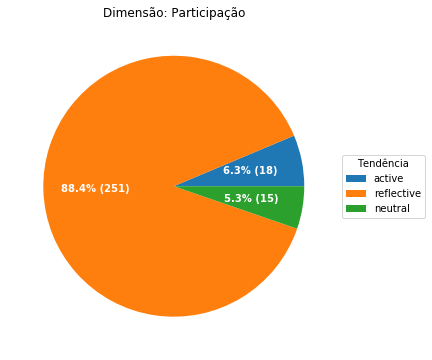

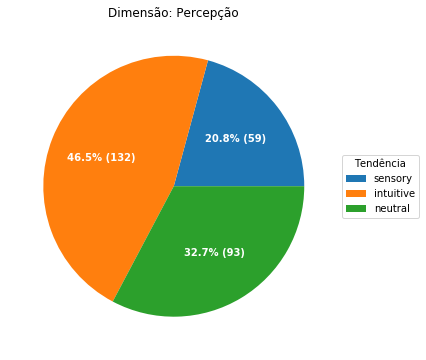

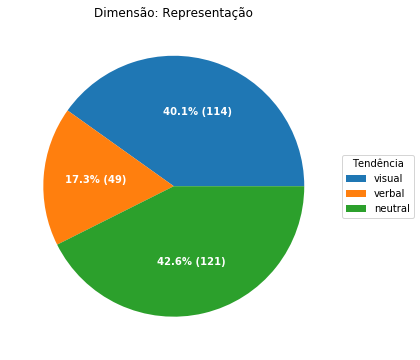

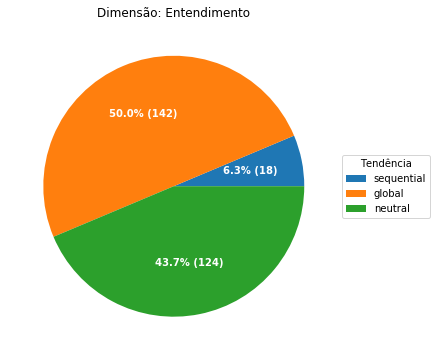

In [20]:
#
pieChart([val for val in processing.values()], ['active', 'reflective','neutral'], legendTitle = "Tendência", title="Dimensão: Participação")
pieChart([val for val in perception.values()], ['sensory', 'intuitive','neutral'], legendTitle = "Tendência", title="Dimensão: Percepção")
pieChart([val for val in representation.values()], ['visual', 'verbal','neutral'], legendTitle = "Tendência", title="Dimensão: Representação")
pieChart([val for val in understanding.values()], ['sequential', 'global','neutral'], legendTitle = "Tendência", title="Dimensão: Entendimento")

O tipo de aluno que a base melhor atende é aquele que apresenta o EA igual a: reflexivo, intuitivo, neutro (ou visual), global.

### Cobertura de Conceitos  

Quantos conceitos cada material cobre?

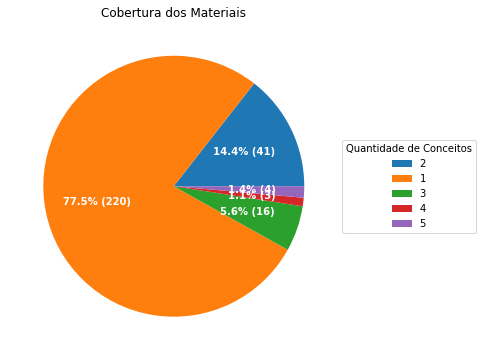

In [21]:
cobertura = pd.read_csv(material_coverage_file, sep=';', names=['id', 'conceito_1', 'conceito_2', 'conceito_3', 'conceito_4', 'conceito_5'])
cobertura = cobertura.set_index('id')

values = list(Counter(cobertura.count(axis='columns')).values())
pieChart(values,['2', '1', '3', '4', '5'], legendTitle = "Quantidade de Conceitos", title="Cobertura dos Materiais" )

Quais são os conceitos que os materiais cobrem? Distribuição dos conceitos.

In [22]:
quantConceitos = cobertura.stack().value_counts().to_dict()
quantConceitos

{'ICL03': 19,
 'ICSN01': 18,
 'ICFA01': 17,
 'ICFSOOC01': 17,
 'ICFA02': 16,
 'ICRC02': 16,
 'ICRC03': 16,
 'ICL02': 15,
 'ICSN03': 14,
 'ICFBD01': 14,
 'ICES03': 13,
 'ICFSOOC02': 13,
 'ICRC01': 13,
 'ICRC04': 13,
 'ICRC05': 12,
 'ICFBD02': 12,
 'ICES02': 12,
 'ICHCC01': 12,
 'ICFSOOC03': 12,
 'ICFA03': 12,
 'ICHCC02': 11,
 'ICHCC04': 11,
 'ICES01': 11,
 'ICFBD03': 11,
 'ICHCC05': 11,
 'ICHCC03': 11,
 'ICSN02': 11,
 'ICHCC06': 9,
 'ICSN04': 9}

A lista de conceitos não apresenta o conceito 'ICL01' (O que é Lógica) e este conceito também não foi indicado para nenhum aluno.

In [23]:
reader = csv.reader(open(material_coverage_file), delimiter=";")

cobertura_ToDict = {} 
for row in reader:
    key = row[0]
    if key in cobertura_ToDict:
        # implement your duplicate row handling here
        pass
    cobertura_ToDict[key] = row[1:]

# ex.: {'0': ['ICFA01', 'ICFA02'], '1': ['ICFA01', 'ICFA02'], ...}

In [24]:
d = defaultdict(list) # ex.: {'ICFSOOC03': ['253', '273', ...,'283'], 'ICL01':[]}
for k, v in cobertura_ToDict.items(): 
    for i in v:
        d[i].append(k)

d.update({'ICL01': []})
        
Dd = defaultdict(list)
for k,v in d.items():
    Dd[k].append(v)
    
conceitosDict = dict(Dd)


print(conceitosDict)

{'ICFA01': [['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']], 'ICFA02': [['0', '1', '2', '3', '4', '5', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26']], 'ICFA03': [['27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']], 'ICHCC01': [['39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50']], 'ICHCC02': [['39', '40', '41', '52', '53', '54', '56', '57', '58', '60', '61']], 'ICHCC06': [['51', '55', '59', '95', '96', '97', '98', '99', '100']], 'ICHCC03': [['62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']], 'ICHCC04': [['73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83']], 'ICHCC05': [['84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94']], 'ICFBD01': [['101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114']], 'ICFBD02': [['101', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125']], 'ICFBD03':

In [25]:
dictMaterialStyles= dict()
for item in materialStyles:
    dictMaterialStyles[list(item.keys())[0]] = list(item.values())[0]
    
# dictMaterialStyles --> {255: ['reflective', 'intuitive', 'visual', 'global'], ... }

difficultyDict= difficultyCol.difficulty.to_dict()
# difficultyDict --> {0: 'Difficulty.VERY_EASY', ... }

typicalLearningTimeDict =  typicalLearningTimeCol.typicalLearningTime.to_dict()
# typicalLearningTimeDict --> {0: datetime.time(0, 15, 17), 1: datetime.time(0, 6), ... }

In [26]:
def conceitosDictAddValues(otherDict): # adiciona lista de valores ao dicionário a partir de outro dict 
    lenVal = len(conceitosDict['ICHCC02'])
    for k, v in conceitosDict.items():
        abc = []
        conceitosDict[k].append(abc)
        for i in v[0]:
            ls = otherDict.get(int(i))
            if ls not in list(conceitosDict[k][lenVal]):
                abc.append(ls)

conceitosDictAddValues(dictMaterialStyles)
conceitosDictAddValues(difficultyDict)
conceitosDictAddValues(typicalLearningTimeDict)


In [27]:
# conceitosDict

In [131]:
pd.set_option('display.max_colwidth', -1)
conceitosStats = pd.DataFrame.from_dict(Dd).transpose()
conceitosStats.columns = ["Materiais","Estilos de Aprendizagem", "Dificuldades", "Tempos de Aprendizagem"]
conceitosStats

,Materiais,Estilos de Aprendizagem,Dificuldades,Tempos de Aprendizagem
ICFA01,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]","[[reflective, intuitive, visual, sequential], [reflective, neutral_2, visual, global], [reflective, intuitive, visual, global], [reflective, intuitive, neutral_4, neutral_6], [reflective, intuitive, neutral_4, global], [reflective, neutral_2, verbal, neutral_6], [reflective, sensory, verbal, neutral_6], [reflective, neutral_2, visual, sequential]]","[Difficulty.VERY_EASY, Difficulty.MEDIUM, Difficulty.VERY_DIFFICULT, Difficulty.DIFFICULT]","[00:15:17, 00:06:00, 00:19:06, 00:44:17, 00:17:48, 00:08:26, 00:21:34, 00:18:02, 02:57:17, 00:13:06, 00:21:47, 00:33:51, 00:10:06, 00:16:03, 01:02:46, 02:52:12, 00:21:06]"
ICFA02,"[0, 1, 2, 3, 4, 5, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]","[[reflective, intuitive, visual, sequential], [reflective, neutral_2, visual, global], [reflective, intuitive, visual, global], [reflective, intuitive, neutral_4, neutral_6], [reflective, intuitive, neutral_4, global], [reflective, sensory, visual, global], [reflective, neutral_2, neutral_4, neutral_6], [reflective, sensory, neutral_4, sequential]]","[Difficulty.VERY_EASY, Difficulty.MEDIUM, Difficulty.DIFFICULT]","[00:15:17, 00:06:00, 00:19:06, 00:44:17, 00:17:48, 00:08:26, 00:29:26, 00:08:44, 00:29:41, 00:28:57, 00:19:45, 00:19:01, 00:58:57, 00:06:34, 01:09:06, 00:23:17]"
ICFA03,"[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]","[[reflective, intuitive, neutral_4, global], [reflective, intuitive, visual, global], [reflective, intuitive, neutral_4, neutral_6], [reflective, neutral_2, verbal, neutral_6], [reflective, neutral_2, neutral_4, global]]","[Difficulty.MEDIUM, Difficulty.VERY_DIFFICULT, Difficulty.DIFFICULT, Difficulty.VERY_EASY]","[00:10:50, 01:57:30, 00:16:54, 00:22:27, 00:09:41, 00:08:00, 00:05:00, 00:08:12, 01:13:31, 00:06:07, 00:11:13, 00:30:05]"
ICHCC01,"[39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]","[[reflective, intuitive, visual, global], [reflective, neutral_2, visual, global], [reflective, neutral_2, verbal, neutral_6], [reflective, intuitive, neutral_4, global], [active, neutral_2, visual, neutral_6]]","[Difficulty.MEDIUM, Difficulty.VERY_EASY]","[00:40:51, 00:48:13, 00:36:42, 00:30:31, 01:03:02, 00:44:06, 00:16:32, 01:05:30, 00:50:11, 00:24:53, 00:08:25, 00:21:49]"
ICHCC02,"[39, 40, 41, 52, 53, 54, 56, 57, 58, 60, 61]","[[reflective, intuitive, visual, global], [reflective, neutral_2, visual, global], [reflective, intuitive, neutral_4, global]]","[Difficulty.MEDIUM, Difficulty.VERY_EASY, Difficulty.VERY_DIFFICULT]","[00:40:51, 00:48:13, 00:36:42, 00:57:59, 00:05:53, 00:19:47, 00:40:37, 00:29:04, 01:41:49, 00:02:40, 00:38:53]"
ICHCC06,"[51, 55, 59, 95, 96, 97, 98, 99, 100]","[[reflective, neutral_2, verbal, neutral_6], [reflective, intuitive, neutral_4, global], [reflective, intuitive, visual, global], [reflective, sensory, neutral_4, global], [reflective, sensory, visual, global], [neutral_0, sensory, neutral_4, neutral_6], [reflective, neutral_2, visual, neutral_6]]","[Difficulty.VERY_EASY, Difficulty.VERY_DIFFICULT, Difficulty.MEDIUM]","[00:25:32, 00:42:08, 00:02:00, 00:38:09, 00:04:00, 00:09:27, 00:54:00, 00:08:00, 00:06:02]"
ICHCC03,"[62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]","[[reflective, intuitive, neutral_4, global], [neutral_0, intuitive, visual, neutral_6], [reflective, intuitive, visual, global], [reflective, neutral_2, verbal, neutral_6], [active, sensory, verbal, sequential]]","[Difficulty.VERY_EASY, Difficulty.MEDIUM, Difficulty.DIFFICULT]","[00:02:40, 00:25:04, 00:07:05, 00:33:56, 00:30:47, 00:10:47, 00:30:31, 00:19:59, 00:09:32, 02:39:50, 00:21:50]"
ICHCC04,"[73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]","[[reflective, intuitive, visual, global], [reflective, intuitive, neutral_4, global], [reflective, intuitive, neutral_4, neutral_6], [neutral_0, neutral_2, neutral_4, sequential], [active, sensory, verbal, sequential], [reflective, neutral_2, visual, global]]","[Difficult

## Materiais entregues 

Carregar da sequência curricular definida para cada aluno e transformar para array. <br>
Depois fazer um dicio onde o material é a key e o value é uma tupla (quantidadeFalse, quantidadeTrue). <br>


In [29]:

header = ['material_' + str(i) for i in range(0,284)]

data = pd.read_csv(studentXselectedMaterials_file, names=header)

df = pd.DataFrame(data)

dataset = df.apply(pd.Series.value_counts).to_dict() # conta a quantidade de False e True de cada material(coluna)

materialDict = dict() 

for material, materialCount in dataset.items(): # dataset -> {'material_1': {False: 18, True: 6}, ... }
    for key, value in materialCount.items():
        if(np.isnan(value)):
            materialCount[key] = int(0)
        elif(isinstance(value, float)):
            materialCount[key] = int(value)
            
        materialDict[material] = list(materialCount.values())


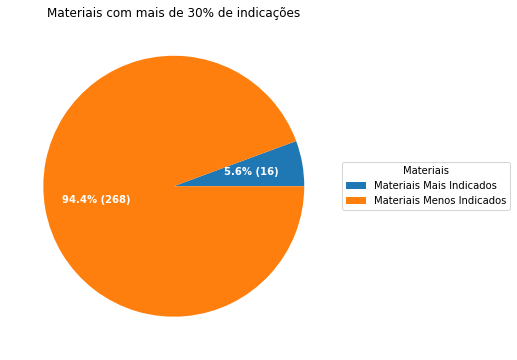

In [30]:
# se um material x foi indicado menos que 30% (17 de 24) das vezes, ou seja, se o número de falso for maior que 17, então:

materiaisMaisEscolhidos = set()
materiaisMenosEscolhidos = set()

for key, value in materialDict.items(): # materialDict -> {'material_1': (18, 6), ...}
    if(value[0] >= 17): #value[0] = False
        materiaisMenosEscolhidos.add(key)
    else:
        materiaisMaisEscolhidos.add(key)
    

labels = ['Materiais Mais Indicados', 'Materiais Menos Indicados']
values = [len(materiaisMaisEscolhidos), len(materiaisMenosEscolhidos)]

pieChart(values, labels, legendTitle = "Materiais", title="Materiais com mais de 30% de indicações")

<b>% de indicações X % de materiais</b>

Counter({0.0: 35.2112676056338, 5.0: 20.070422535211268, 9.0: 13.028169014084506, 13.0: 11.267605633802818, 17.0: 4.929577464788732, 21.0: 3.873239436619718, 30.0: 3.169014084507042, 25.0: 2.8169014084507045, 38.0: 2.8169014084507045, 34.0: 1.4084507042253522, 50.0: 0.7042253521126761, 42.0: 0.35211267605633806, 55.00000000000001: 0.35211267605633806})


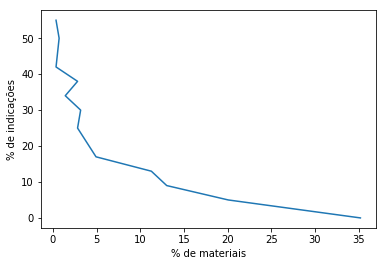

In [31]:
for key, value in materialDict.items():
    materialDict[key] += [round_up(value[1]/(value[0]+ value[1]), 2) ] # porcentagem de indicação

values = Counter([val[2] * 100for val in materialDict.values()]) # porcentagem de indicação: quantidade de materiais

for key, val in values.items(): 
    values[key] = (val/284) * 100
    
print(values) # porcentagem de indicação: porcentagem de materiais

values = OrderedDict(sorted(values.items()))

plt.plot(values.values(),values.keys())
plt.xlabel("% de materiais")
plt.ylabel("% de indicações")
plt.show()

In [32]:
valoresFalsos = pd.Series(value[0] for value in materialDict.values())
valoresVerdadeiros = pd.Series(value[1] for value in materialDict.values())

print("Valores Verdadeiros:\n\n")
print(valoresVerdadeiros.describe())
print("\nMediana de Valores Verdadeiros: " + str(valoresVerdadeiros.median()))

print("Valores Falsos:\n\n")
print(valoresFalsos.describe())
print("\nMediana de Valores Falsos: " + str(valoresFalsos.median()))

Valores Verdadeiros:


count    284.000000
mean     2.112676  
std      2.600893  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      3.000000  
max      13.000000 
dtype: float64

Mediana de Valores Verdadeiros: 1.0
Valores Falsos:


count    284.000000
mean     21.887324 
std      2.600893  
min      11.000000 
25%      21.000000 
50%      23.000000 
75%      24.000000 
max      24.000000 
dtype: float64

Mediana de Valores Falsos: 23.0


<b>Estilo de aprendizagem: </b>

In [33]:
dictMaterialsLS = dict()

for dici in materialStyles:
    dictMaterialsLS.update(dici)

materials16 = list()
for material in materiaisMaisEscolhidos:
    mat = [int(material.strip('material_'))]
    mat.append(lom_df.loc[lom_df['identifier'] == mat[0]].difficulty.values[0])
    mat.append(lom_df.loc[lom_df['identifier'] == mat[0]].typicalLearningTime.values[0])
    mat.append(dictMaterialsLS[mat[0]])
    materials16.append(mat)
    
best16 = pd.DataFrame(materials16, columns=['identifier', 'Difficulty', 'typicalLearningTime', 'LS'])
best16

,identifier,Difficulty,typicalLearningTime,LS
0,155,Difficulty.MEDIUM,00:27:35,"[reflective, neutral_2, neutral_4, neutral_6]"
1,18,Difficulty.MEDIUM,00:02:00,"[reflective, intuitive, neutral_4, neutral_6]"
2,141,Difficulty.MEDIUM,00:06:41,"[reflective, neutral_2, visual, global]"
3,184,Difficulty.DIFFICULT,00:46:41,"[reflective, intuitive, visual, global]"
4,212,Difficulty.MEDIUM,00:21:50,"[reflective, sensory, neutral_4, neutral_6]"
5,156,Difficulty.MEDIUM,00:16:11,"[reflective, neutral_2, neutral_4, neutral_6]"
6,239,Difficulty.DIFFICULT,00:30:31,"[reflective, intuitive, neutral_4, global]"
7,27,Difficulty.DIFFICULT,00:05:24,"[reflective, intuitive, neutral_4, global]"
8,5,Difficulty.MEDIUM,00:11:37,"[reflective, intuitive, neutral_4, global]"
9,119,Difficulty.MEDIUM,00:13:59,"[reflective, intuitive, visual, global]"


In [34]:
best16LS = sum((Counter(x) for x in list(map(Counter, best16.LS))),Counter())

print(best16LS)


Counter({'reflective': 16, 'global': 10, 'intuitive': 9, 'neutral_4': 8, 'visual': 7, 'neutral_2': 6, 'neutral_6': 5, 'sensory': 1, 'sequential': 1, 'verbal': 1})


{'reflective': 16}
{'neutral_2': 6, 'intuitive': 9, 'sensory': 1}
{'neutral_4': 8, 'visual': 7, 'verbal': 1}
{'neutral_6': 5, 'global': 10, 'sequential': 1}


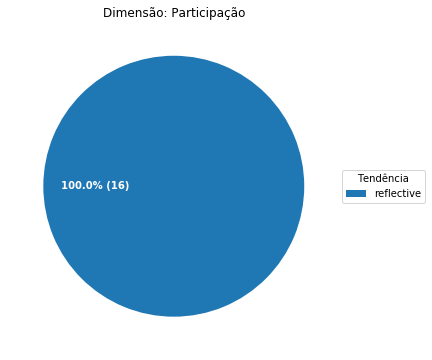

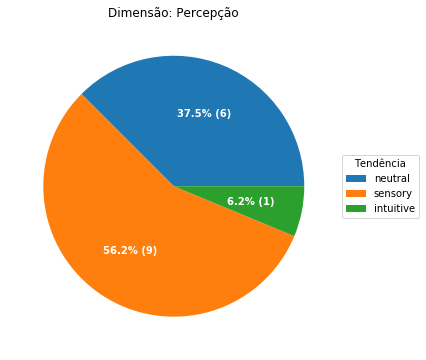

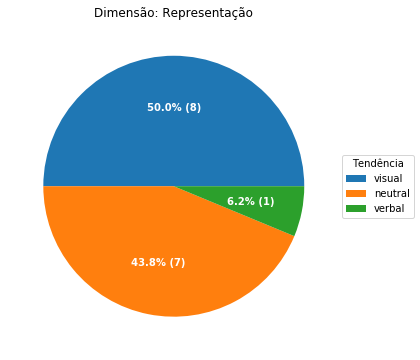

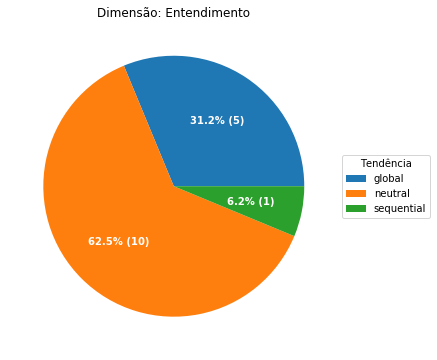

In [35]:
processing16 = { key:value for (key,value) in best16LS.items() if key in ['reflective', 'active','neutral_0'] }
print(processing16)
perception16 = {key:value for (key,value) in best16LS.items() if key in ['intuitive','sensory','neutral_2']}
print(perception16)
representation16 = {key:value for (key,value) in best16LS.items() if key in ['neutral_4','visual', 'verbal']}
print(representation16)
understanding16 = {key:value for (key,value) in best16LS.items() if key in ['global','neutral_6', 'sequential']}
print(understanding16)

pieChart([val for val in processing16.values()] , ['reflective', 'active','neutral'], legendTitle = "Tendência", title="Dimensão: Participação")
pieChart([val for val in perception16.values()], ['neutral','sensory', 'intuitive'], legendTitle = "Tendência", title="Dimensão: Percepção")
pieChart([val for val in representation16.values()], ['visual', 'neutral', 'verbal'], legendTitle = "Tendência", title="Dimensão: Representação")
pieChart([val for val in understanding16.values()], ['global','neutral', 'sequential'], legendTitle = "Tendência", title="Dimensão: Entendimento")


O EA que os materiais mais indicados melhor atendem é: reflexivo, intuitivo, neutro (ou visual), global. O que corresponde com o EA que a base melhor atende.

<b>Cobertura de Conceitos:</b> Quantos conceitos os 16 melhores materiais cobrem?

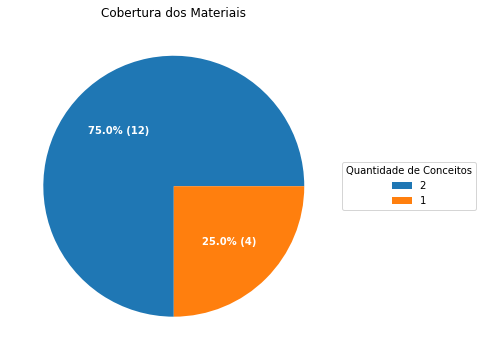

In [36]:
coberturaCount = cobertura.count(axis='columns')
cobertura16 = list()
for material in materiaisMaisEscolhidos:
    mat = [int(material.strip('material_'))]
    mat.append(coberturaCount.loc[mat[0]])
    cobertura16.append(mat[1])
    
pieChart(list(Counter(cobertura16).values()),['2', '1'], legendTitle = "Quantidade de Conceitos", title="Cobertura dos Materiais" )

Quais são os conceitos que os materiais mais indicados cobrem? Distribuição dos conceitos.

In [37]:

quantConceitos16 = list()
for material in materiaisMaisEscolhidos:
    mat = [int(material.strip('material_'))]
    quantConceitos16.append(cobertura.loc[mat[0]-1].value_counts().to_dict())

quantConceitos16 = sum((Counter(x) for x in quantConceitos16),Counter()) 
quantConceitos16

Counter({'ICES03': 2,
         'ICFA02': 4,
         'ICES02': 3,
         'ICES01': 2,
         'ICRC03': 2,
         'ICL03': 1,
         'ICSN01': 1,
         'ICFA01': 2,
         'ICFBD02': 1,
         'ICHCC02': 1,
         'ICFSOOC02': 1,
         'ICRC02': 1})

# Caracterização dos alunos

Utilizando os 24 perfis criados pelo André.

In [138]:
conceito = ['conceitoID_' + str(i) for i in range(1,30)]
learners = pd.read_csv(learners_test_file, sep=';', names=['id', 'timeMin', 'timeMax', 'ativo_reflexivo', 'sensorial_intuitivo', 'visual_verbal', 'sequencial_global'] + conceito)
learners = learners.set_index('id')
learners = learners.drop(columns=["timeMin"]) # todos os valores são 0

learners.head()

,timeMax,ativo_reflexivo,sensorial_intuitivo,visual_verbal,sequencial_global,conceitoID_1,conceitoID_2,conceitoID_3,conceitoID_4,conceitoID_5,conceitoID_6,conceitoID_7,conceitoID_8,conceitoID_9,conceitoID_10,conceitoID_11,conceitoID_12,conceitoID_13,conceitoID_14,conceitoID_15,conceitoID_16,conceitoID_17,conceitoID_18,conceitoID_19,conceitoID_20,conceitoID_21,conceitoID_22,conceitoID_23,conceitoID_24,conceitoID_25,conceitoID_26,conceitoID_27,conceitoID_28,conceitoID_29
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,11,11,11,11,ICHCC01,ICHCC02,ICHCC03,ICHCC04,ICHCC05,ICHCC06,ICSN01,ICSN02,ICSN03,ICSN04,ICL02,ICL03,ICFA01,ICFA02,ICFA03,ICFBD01,ICFBD02,ICFBD03,ICES01,ICES02,ICES03,ICFSOOC01,ICFSOOC02,ICFSOOC03,ICRC01,ICRC02,ICRC03,ICRC04,ICRC05
1,1,11,11,11,11,ICHCC01,ICHCC02,ICHCC03,ICHCC04,ICHCC05,ICHCC06,ICSN01,ICSN02,ICSN03,ICSN04,ICL02,ICL03,ICFA01,ICFA02,ICFA03,ICFBD01,ICFBD02,ICFBD03,ICES01,ICES02,ICES03,ICFSOOC01,ICFSOOC02,ICFSOOC03,ICRC01,ICRC02,ICRC03,ICRC04,ICRC05
2,1,11,11,11,11,ICHCC01,ICHCC02,ICHCC03,ICHCC04,ICSN01,ICSN02,ICSN03,ICL02,ICL03,ICFA01,ICFA02,ICFBD01,ICFBD02,ICES01,ICES02,ICFSOOC01,ICFSOOC02,ICFSOOC03,ICRC01,ICRC02,ICRC03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,11,11,11,11,ICHCC01,ICHCC02,ICHCC03,ICHCC04,ICSN01,ICSN02,ICSN03,ICL02,ICL03,ICFA01,ICFA02,ICFBD01,ICFBD02,ICES01,ICES02,ICFSOOC01,ICFSOOC02,ICFSOOC03,ICRC01,ICRC02,ICRC03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,11,11,11,11,ICHCC01,ICHCC02,ICSN01,ICL02,ICFBD01,ICES01,ICFSOOC01,ICFSOOC02,ICRC01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
conceitosDF = learners[conceito]
conceitosDF = pd.get_dummies(conceitosDF, prefix="", prefix_sep='',)
conceitosDF = conceitosDF.groupby(level=0, axis=1).sum() # colunas com nomes iguais
conceitosDF.insert(loc=0, column='ICL01', value=pd.Series([int(0) for i in range(25)])) # com valores zerados para todos os alunos,
                                                                                        # pois esse conceito não foi indicado para ninguém
for col in conceitosDF.columns:
    conceitosDF[col]= conceitosDF[col].astype('Int32')
    
conceitosDF.head()

,ICL01,ICES01,ICES02,ICES03,ICFA01,ICFA02,ICFA03,ICFBD01,ICFBD02,ICFBD03,ICFSOOC01,ICFSOOC02,ICFSOOC03,ICHCC01,ICHCC02,ICHCC03,ICHCC04,ICHCC05,ICHCC06,ICL02,ICL03,ICRC01,ICRC02,ICRC03,ICRC04,ICRC05,ICSN01,ICSN02,ICSN03,ICSN04
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0
3,0,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0
4,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0


In [140]:
learners = learners.drop(columns=conceito)
learners = learners.join(conceitosDF)
learners.head()

,timeMax,ativo_reflexivo,sensorial_intuitivo,visual_verbal,sequencial_global,ICL01,ICES01,ICES02,ICES03,ICFA01,ICFA02,ICFA03,ICFBD01,ICFBD02,ICFBD03,ICFSOOC01,ICFSOOC02,ICFSOOC03,ICHCC01,ICHCC02,ICHCC03,ICHCC04,ICHCC05,ICHCC06,ICL02,ICL03,ICRC01,ICRC02,ICRC03,ICRC04,ICRC05,ICSN01,ICSN02,ICSN03,ICSN04
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,11,11,11,11,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,11,11,11,11,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,11,11,11,11,0,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0
3,1,11,11,11,11,0,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0
4,1,11,11,11,11,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0


Aqui os valores do EA foram simplificados para o ou 1 

In [147]:
learners.loc[learners.ativo_reflexivo > 0, "ativo_reflexivo"] = 1
learners.loc[learners.ativo_reflexivo < 0, "ativo_reflexivo"] = 0
learners.loc[learners.sensorial_intuitivo > 0, "sensorial_intuitivo"] = 1
learners.loc[learners.sensorial_intuitivo < 0, "sensorial_intuitivo"] = 0
learners.loc[learners.visual_verbal > 0, "visual_verbal"] = 1
learners.loc[learners.visual_verbal < 0, "visual_verbal"] = 0
learners.loc[learners.sequencial_global > 0, "sequencial_global"] = 1
learners.loc[learners.sequencial_global < 0, "sequencial_global"] = 0
learners.head()

,timeMax,ativo_reflexivo,sensorial_intuitivo,visual_verbal,sequencial_global,ICL01,ICES01,ICES02,ICES03,ICFA01,ICFA02,ICFA03,ICFBD01,ICFBD02,ICFBD03,ICFSOOC01,ICFSOOC02,ICFSOOC03,ICHCC01,ICHCC02,ICHCC03,ICHCC04,ICHCC05,ICHCC06,ICL02,ICL03,ICRC01,ICRC02,ICRC03,ICRC04,ICRC05,ICSN01,ICSN02,ICSN03,ICSN04
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,0,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0
3,1,1,1,1,1,0,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0
4,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0


#### Estilo de Aprendizagem 

Dos 24 alunos, existem apenas dois perfis em relação aos EA sendo o primeiro: ativo, sensorial, visal, sequencial e o segundo: reflexivo, intuitivo, verbal, global. No qual o perfil 2 é aquele que a base de materiais melhor atende, por conta disso, os alunos desse perfil apresentam os melhores valores de função de fitness referente ao EA.

Verificar se houve algum conceito não coberto:

In [132]:
reader = csv.reader(open(learners_test_file), delimiter=";")

alunosConcetosIndicados = dict()

for i, row in enumerate(reader):
    alunosConcetosIndicados[i] = row[7:]

alunosConcetosIndicados

{0: ['ICHCC01',
  'ICHCC02',
  'ICHCC03',
  'ICHCC04',
  'ICHCC05',
  'ICHCC06',
  'ICSN01',
  'ICSN02',
  'ICSN03',
  'ICSN04',
  'ICL02',
  'ICL03',
  'ICFA01',
  'ICFA02',
  'ICFA03',
  'ICFBD01',
  'ICFBD02',
  'ICFBD03',
  'ICES01',
  'ICES02',
  'ICES03',
  'ICFSOOC01',
  'ICFSOOC02',
  'ICFSOOC03',
  'ICRC01',
  'ICRC02',
  'ICRC03',
  'ICRC04',
  'ICRC05'],
 1: ['ICHCC01',
  'ICHCC02',
  'ICHCC03',
  'ICHCC04',
  'ICHCC05',
  'ICHCC06',
  'ICSN01',
  'ICSN02',
  'ICSN03',
  'ICSN04',
  'ICL02',
  'ICL03',
  'ICFA01',
  'ICFA02',
  'ICFA03',
  'ICFBD01',
  'ICFBD02',
  'ICFBD03',
  'ICES01',
  'ICES02',
  'ICES03',
  'ICFSOOC01',
  'ICFSOOC02',
  'ICFSOOC03',
  'ICRC01',
  'ICRC02',
  'ICRC03',
  'ICRC04',
  'ICRC05'],
 2: ['ICHCC01',
  'ICHCC02',
  'ICHCC03',
  'ICHCC04',
  'ICSN01',
  'ICSN02',
  'ICSN03',
  'ICL02',
  'ICL03',
  'ICFA01',
  'ICFA02',
  'ICFBD01',
  'ICFBD02',
  'ICES01',
  'ICES02',
  'ICFSOOC01',
  'ICFSOOC02',
  'ICFSOOC03',
  'ICRC01',
  'ICRC02',
  'ICRC0

In [144]:
header_studentsSelectedMaterial = list(lom_df.identifier)
studentsSelectedMaterial = pd.read_csv(studentXselectedMaterials_file, names=header_studentsSelectedMaterial)
studentsSelectedMaterial = studentsSelectedMaterial.replace({False:0, True:1})
studentsSelectedMaterial.index -= 1 
studentsSelectedMaterial.head()

,255,269,279,262,278,271,280,265,264,268,277,254,266,256,261,276,273,253,270,282,263,260,275,259,267,274,258,281,283,272,257,199,236,244,203,232,247,248,215,208,207,213,225,219,222,235,221,227,224,252,234,220,246,205,226,238,217,198,233,237,209,201,240,245,243,197,214,210,239,206,216,200,212,250,204,223,218,228,241,231,202,251,229,211,230,249,242,36,30,8,37,20,38,22,6,1,3,26,7,24,21,15,4,11,19,14,23,10,33,13,28,29,9,2,25,16,0,12,32,18,17,27,34,5,35,31,75,46,62,53,56,52,51,67,68,69,64,71,41,76,39,73,66,60,70,43,63,50,45,54,40,55,59,72,61,58,49,42,74,47,57,65,48,44,111,116,121,113,105,88,80,101,106,104,117,85,78,108,134,131,89,96,122,94,103,128,92,115,81,97,114,102,98,124,91,126,130,109,127,86,93,83,100,118,129,82,79,125,84,112,133,110,120,90,87,99,119,123,77,107,95,132,195,163,153,158,150,184,140,167,192,136,145,191,142,182,159,188,180,171,194,186,151,189,193,149,183,156,157,154,146,164,187,139,161,177,138,148,178,168,152,185,176,143,166,162,160,135,173,141,196,181,137,144,165,179,174,169,175,190,170,155,147,172
0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [145]:
for aluno in range(0, 24):
    conceitosCobertos = set()
    conceitosNaoCobertos = set()
    conceitosAdicionais = set()
    
    conceitosIndicados = set(alunosConcetosIndicados[aluno])
    todosConceitos = list(conceitosStats.index)
    
    for material in header_studentsSelectedMaterial:
        materialRecomendadoValue = studentsSelectedMaterial.loc[aluno,[material]].values[0]
        
        if(materialRecomendadoValue == 1):        
            for conceito in todosConceitos:

                conceitoIndicado = True if conceito in conceitosIndicados else False
                materiais = set(conceitosStats.loc[conceito,['Materiais']].values[0])

                if(str(material) in materiais):
                    if(conceitoIndicado):
                        conceitosCobertos.add(conceito)
                    else:
                        conceitosAdicionais.add(conceito)


        conceitosNaoCobertos = conceitosIndicados - conceitosCobertos
    
    print("Aluno {}:\n\t Conceitos cobertos: {}\n\t Conceitos Não Cobertos: {}\n\t Conceitos Adicionais: {}".format(aluno, len(conceitosCobertos), len(conceitosNaoCobertos), len(conceitosAdicionais)))

Aluno 0:
	 Conceitos cobertos: 29
	 Conceitos Não Cobertos: 0
	 Conceitos Adicionais: 0
Aluno 1:
	 Conceitos cobertos: 29
	 Conceitos Não Cobertos: 0
	 Conceitos Adicionais: 0
Aluno 2:
	 Conceitos cobertos: 21
	 Conceitos Não Cobertos: 0
	 Conceitos Adicionais: 0
Aluno 3:
	 Conceitos cobertos: 21
	 Conceitos Não Cobertos: 0
	 Conceitos Adicionais: 0
Aluno 4:
	 Conceitos cobertos: 9
	 Conceitos Não Cobertos: 0
	 Conceitos Adicionais: 0
Aluno 5:
	 Conceitos cobertos: 9
	 Conceitos Não Cobertos: 0
	 Conceitos Adicionais: 1
Aluno 6:
	 Conceitos cobertos: 29
	 Conceitos Não Cobertos: 0
	 Conceitos Adicionais: 0
Aluno 7:
	 Conceitos cobertos: 29
	 Conceitos Não Cobertos: 0
	 Conceitos Adicionais: 0
Aluno 8:
	 Conceitos cobertos: 21
	 Conceitos Não Cobertos: 0
	 Conceitos Adicionais: 0
Aluno 9:
	 Conceitos cobertos: 21
	 Conceitos Não Cobertos: 0
	 Conceitos Adicionais: 0
Aluno 10:
	 Conceitos cobertos: 9
	 Conceitos Não Cobertos: 0
	 Conceitos Adicionais: 0
Aluno 11:
	 Conceitos cobertos: 9


Os alunos 5 e 23 tiveram um conceito adicional coberto e portanto, o valor da função objetivo, que avalia os conceitos cobertos, para esses alunos tem o valor 1.0. 

In [46]:
conceitosStats

,Materiais,Estilos de Aprendizagem,Dificuldades,Tempos de Aprendizagem
ICFA01,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]","[[reflective, intuitive, visual, sequential], [reflective, neutral_2, visual, global], [reflective, intuitive, visual, global], [reflective, intuitive, neutral_4, neutral_6], [reflective, intuitive, neutral_4, global], [reflective, neutral_2, verbal, neutral_6], [reflective, sensory, verbal, neutral_6], [reflective, neutral_2, visual, sequential]]","[Difficulty.VERY_EASY, Difficulty.MEDIUM, Difficulty.VERY_DIFFICULT, Difficulty.DIFFICULT]","[00:15:17, 00:06:00, 00:19:06, 00:44:17, 00:17:48, 00:08:26, 00:21:34, 00:18:02, 02:57:17, 00:13:06, 00:21:47, 00:33:51, 00:10:06, 00:16:03, 01:02:46, 02:52:12, 00:21:06]"
ICFA02,"[0, 1, 2, 3, 4, 5, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]","[[reflective, intuitive, visual, sequential], [reflective, neutral_2, visual, global], [reflective, intuitive, visual, global], [reflective, intuitive, neutral_4, neutral_6], [reflective, intuitive, neutral_4, global], [reflective, sensory, visual, global], [reflective, neutral_2, neutral_4, neutral_6], [reflective, sensory, neutral_4, sequential]]","[Difficulty.VERY_EASY, Difficulty.MEDIUM, Difficulty.DIFFICULT]","[00:15:17, 00:06:00, 00:19:06, 00:44:17, 00:17:48, 00:08:26, 00:29:26, 00:08:44, 00:29:41, 00:28:57, 00:19:45, 00:19:01, 00:58:57, 00:06:34, 01:09:06, 00:23:17]"
ICFA03,"[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]","[[reflective, intuitive, neutral_4, global], [reflective, intuitive, visual, global], [reflective, intuitive, neutral_4, neutral_6], [reflective, neutral_2, verbal, neutral_6], [reflective, neutral_2, neutral_4, global]]","[Difficulty.MEDIUM, Difficulty.VERY_DIFFICULT, Difficulty.DIFFICULT, Difficulty.VERY_EASY]","[00:10:50, 01:57:30, 00:16:54, 00:22:27, 00:09:41, 00:08:00, 00:05:00, 00:08:12, 01:13:31, 00:06:07, 00:11:13, 00:30:05]"
ICHCC01,"[39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]","[[reflective, intuitive, visual, global], [reflective, neutral_2, visual, global], [reflective, neutral_2, verbal, neutral_6], [reflective, intuitive, neutral_4, global], [active, neutral_2, visual, neutral_6]]","[Difficulty.MEDIUM, Difficulty.VERY_EASY]","[00:40:51, 00:48:13, 00:36:42, 00:30:31, 01:03:02, 00:44:06, 00:16:32, 01:05:30, 00:50:11, 00:24:53, 00:08:25, 00:21:49]"
ICHCC02,"[39, 40, 41, 52, 53, 54, 56, 57, 58, 60, 61]","[[reflective, intuitive, visual, global], [reflective, neutral_2, visual, global], [reflective, intuitive, neutral_4, global]]","[Difficulty.MEDIUM, Difficulty.VERY_EASY, Difficulty.VERY_DIFFICULT]","[00:40:51, 00:48:13, 00:36:42, 00:57:59, 00:05:53, 00:19:47, 00:40:37, 00:29:04, 01:41:49, 00:02:40, 00:38:53]"
ICHCC06,"[51, 55, 59, 95, 96, 97, 98, 99, 100]","[[reflective, neutral_2, verbal, neutral_6], [reflective, intuitive, neutral_4, global], [reflective, intuitive, visual, global], [reflective, sensory, neutral_4, global], [reflective, sensory, visual, global], [neutral_0, sensory, neutral_4, neutral_6], [reflective, neutral_2, visual, neutral_6]]","[Difficulty.VERY_EASY, Difficulty.VERY_DIFFICULT, Difficulty.MEDIUM]","[00:25:32, 00:42:08, 00:02:00, 00:38:09, 00:04:00, 00:09:27, 00:54:00, 00:08:00, 00:06:02]"
ICHCC03,"[62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]","[[reflective, intuitive, neutral_4, global], [neutral_0, intuitive, visual, neutral_6], [reflective, intuitive, visual, global], [reflective, neutral_2, verbal, neutral_6], [active, sensory, verbal, sequential]]","[Difficulty.VERY_EASY, Difficulty.MEDIUM, Difficulty.DIFFICULT]","[00:02:40, 00:25:04, 00:07:05, 00:33:56, 00:30:47, 00:10:47, 00:30:31, 00:19:59, 00:09:32, 02:39:50, 00:21:50]"
ICHCC04,"[73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]","[[reflective, intuitive, visual, global], [reflective, intuitive, neutral_4, global], [reflective, intuitive, neutral_4, neutral_6], [neutral_0, neutral_2, neutral_4, sequential], [active, sensory, verbal, sequential], [reflective, neutral_2, visual, global]]","[Difficult

## Algoritmos de Categorização 

## Base Real: outra representação dos dados 

Aqui tem-se como objetivo incrementar as características de cada material.

Nesse caso abaixo, se o material cobre mais de um conceito ou não.

In [47]:
moreThanOneConcept = pd.DataFrame.from_dict(cobertura.to_dict()['conceito_2'], orient='index', columns=['MoreThanOneConcept'])
moreThanOneConcept.fillna(0)
moreThanOneConcept['MoreThanOneConcept'] = moreThanOneConcept['MoreThanOneConcept'].apply(lambda x: 1 if type(x) == str else 0)
moreThanOneConcept.head()

,MoreThanOneConcept
0,1
1,1
2,1
3,1
4,1


Qual o estilo de aprendizagem do material?

In [48]:
dataFrame = pd.DataFrame.from_dict(dictMaterialsLS, orient='index', columns=['Processing', 'Perception', 'Representation', 'Understanding'])
dataFrame = pd.get_dummies(dataFrame)
dataFrame = dataFrame[['Processing_active', 'Processing_neutral_0', 'Processing_reflective', 'Perception_sensory', 'Perception_neutral_2','Perception_intuitive', 'Representation_visual' , 'Representation_neutral_4', 'Representation_verbal', 'Understanding_sequential', 'Understanding_neutral_6', 'Understanding_global']]
dataFrame.head()

,Processing_active,Processing_neutral_0,Processing_reflective,Perception_sensory,Perception_neutral_2,Perception_intuitive,Representation_visual,Representation_neutral_4,Representation_verbal,Understanding_sequential,Understanding_neutral_6,Understanding_global
255,0,0,1,0,0,1,1,0,0,0,0,1
269,0,0,1,0,0,1,1,0,0,0,0,1
279,0,0,1,0,0,1,1,0,0,0,0,1
262,0,0,1,0,0,1,1,0,0,0,0,1
278,0,0,1,0,0,1,1,0,0,0,0,1


In [49]:

lomDf = pd.read_csv("../LOM_to_csv1.csv", sep=',')
lomDf = lomDf.drop(columns=['title', 'size'] + ['keyword'+str(i) for i in range(39)])
lomDf = lomDf.set_index('identifier')

# adicionando a característica de recomendação:  
lomDf.insert(loc=0, column='recommendation', value=pd.Series([0 for i in range(285)])) # com valores zerados para todos os materiais

for material, value in materialDict.items(): # adicionando 1 para aqueles que foram indicados para algum aluno
    id1 = int(material.strip('material_'))
    if(value[1] != 0):
        val = 1
    else:
        val = 0
    lomDf.at[id1,'recommendation']= val
    
# conventendo todos os valores para int, com exceção da coluna de tempo
cols=[i for i in lomDf.columns if i not in ["typicalLearningTime"]]

for col in cols:
    lomDf[col]= lomDf[col].astype('Int32')

# convertendo a coluna typicalLearningTime de str para datetime.time em segundos
lomDf[['typicalLearningTime']] = lomDf[['typicalLearningTime']].applymap(lambda time_str: (datetime.datetime.strptime(time_str, '%H:%M:%S') - datetime.datetime(1900, 1, 1)).total_seconds()
)

# adicionando as características de estilo de aprendizagem
lomDf = lomDf.join(dataFrame)

# adicionando a característica moreThanOneConcept, onde caso o material apresente mais de um conceito o valor é 1
lomDf = lomDf.join(moreThanOneConcept)

lomDf.head()   

,recommendation,Format.APPLICATION_PDF,Format.IMAGE_PNG,Format.VIDEO_MP4,InteractivityType.ACTIVE,InteractivityType.EXPOSITIVE,InteractivityType.MIXED,LearningResourceType.EXERCISE,LearningResourceType.SIMULATION,LearningResourceType.QUESTIONNAIRE,LearningResourceType.DIAGRAM,LearningResourceType.FIGURE,LearningResourceType.GRAPH,LearningResourceType.INDEX,LearningResourceType.SLIDE,LearningResourceType.TABLE,LearningResourceType.NARRATIVE_TEXT,LearningResourceType.EXAM,LearningResourceType.EXPERIMENT,LearningResourceType.PROBLEM_STATEMENT,LearningResourceType.SELF_ASSESSMENT,LearningResourceType.LECTURE,InteractivityLevel.VERY_LOW,InteractivityLevel.LOW,InteractivityLevel.MEDIUM,InteractivityLevel.HIGH,InteractivityLevel.VERY_HIGH,Difficulty.VERY_EASY,Difficulty.EASY,Difficulty.MEDIUM,Difficulty.DIFFICULT,Difficulty.VERY_DIFFICULT,typicalLearningTime,Processing_active,Processing_neutral_0,Processing_reflective,Perception_sensory,Perception_neutral_2,Perception_intuitive,Representation_visual,Representation_neutral_4,Representation_verbal,Understanding_sequential,Understanding_neutral_6,Understanding_global,MoreThanOneConcept
identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
255,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,917.0,0,0,1,0,0,1,1,0,0,0,0,1,1
269,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,360.0,0,0,1,0,0,1,1,0,0,0,0,1,0
279,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1146.0,0,0,1,0,0,1,1,0,0,0,0,1,0
262,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2657.0,0,0,1,0,0,1,1,0,0,0,0,1,1
278,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1068.0,0,0,1,0,0,1,1,0,0,0,0,1,0


### Produto cartesiano dos alunos com os materiais 

Com o objetivo de melhorar os resultados obtidos pelo classificador, além de utilizar as característica dos materiais também vamos utilizar as características dos alunos.

A operação de produto cartesiano (cross join) será utilizada para calcular todas as possíveis combinações das linhas de dois datasets: <b>lomDf</b> e <b>learners</b>. <br>
O objetivo é definir se um material de lomDf foi indicado a algum aluno de learners.

<b>1:</b> material selecionado para o aluno <br>
<b>0:</b> material não selecionado para o aluno

In [50]:
header = [str(i) for i in range(0,284)]
studentsSelectedMaterial = pd.read_csv(studentXselectedMaterials_file, names=header)
studentsSelectedMaterial = studentsSelectedMaterial.replace({False:0, True:1})
studentsSelectedMaterial.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
def df_crossjoin(df1, df2):
    df1['_tmpkey'] = 1
    df2['_tmpkey'] = 1

    res = pd.merge(df1, df2, on='_tmpkey').drop('_tmpkey', axis=1)
    res.index = pd.MultiIndex.from_product((df1.index, df2.index))

    df1.drop('_tmpkey', axis=1, inplace=True)
    df2.drop('_tmpkey', axis=1, inplace=True)

    return res

In [52]:
def recommendationValue(col):
    indexes = col.name #(aluno, material)
    return studentsSelectedMaterial.loc[indexes[0], str(indexes[1])]

In [53]:
lomDfX = df_crossjoin(learners, lomDf)
lomDfX["recommendation"] = lomDfX.apply(recommendationValue, axis=1)
lomDfX.head()

timeMax  ativo_reflexivo  sensorial_intuitivo  visual_verbal  \
1 255  1        1                1                    1               
  269  1        1                1                    1               
  279  1        1                1                    1               
  262  1        1                1                    1               
  278  1        1                1                    1               

       sequencial_global  ICL01  ICES01  ICES02  ICES03  ICFA01  ICFA02  \
1 255  1                  0      1       1       1       1       1        
  269  1                  0      1       1       1       1       1        
  279  1                  0      1       1       1       1       1        
  262  1                  0      1       1       1       1       1        
  278  1                  0      1       1       1       1       1        

       ICFA03  ICFBD01  ICFBD02  ICFBD03  ICFSOOC01  ICFSOOC02  ICFSOOC03  \
1 255  1       1        1        1        1          1          1           
  269  1       1        1        1        1          1          1           
  279  1       1        1        1        1          1          1           
  262  1       1        1        1        1          1          1           
  278  1       1        1        1        1          1          1           

       ICHCC01  ICHCC02  ICHCC03  ICHCC04  ICHCC05  ICHCC06  ICL02  ICL03  \
1 255  1        1        1        1        1        1        1      1       
  269  1        1        1        1        1        1        1      1       
  279  1        1        1        1        1        1        1      1       
  262  1        1        1        1        1        1        1      1       
  278  1        1        1        1        1        1        1      1       

       ICRC01  ICRC02  ICRC03  ICRC04  ICRC05  ICSN01  ICSN02  ICSN03  ICSN04  \
1 255  1       1       1       1       1       1       1       1       1        
  269  1       1       1       1       1       1       1       1       1        
  279  1       1       1       1       1       1       1       1       1        
  262  1       1       1       1       1       1       1       1       1        
  278  1       1       1       1       1       1       1       1       1        

       recommendation  Format.APPLICATION_PDF  Format.IMAGE_PNG  \
1 255  0               1                       0                  
  269  1               0                       1                  
  279  0               1                       0                  
  262  0               0                       0                  
  278  0               1                       0                  

       Format.VIDEO_MP4  InteractivityType.ACTIVE  \
1 255  0                 0                          
  269  0                 0                          
  279  0                 0                          
  262  1                 0                          
  278  0                 0                          

       InteractivityType.EXPOSITIVE  InteractivityType.MIXED  \
1 255  0                             1                         
  269  1                             0                         
  279  1                             0                         
  262  1                             0                         
  278  1                             0                         

       LearningResourceType.EXERCISE  LearningResourceType.SIMULATION  \
1 255  0                              0                                 
  269  0                              0                                 
  279  0                              0                                 
  262  0                              0                                 
  278  0                              0                                 

       LearningResourceType.QUESTIONNAIRE  LearningResourceType.DIAGRAM  \
1 255  1                                   1                              
  269  0            

In [54]:
len(lomDfX)

6816

### Árvore de decisão 

Ávore de decisão é uma ferramenta de predição e classificação utilizada na área de aprendizagem de máquina. O algoritmo é classificado como um método de aprendizagem supervisionada.

In [55]:
today = datetime.date.today().strftime("%d-%m-%Y")

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# método para a criação da Decision Tree (DT)
def createDT(lomDf, exceptFeatures, targetVariable, test_size=0.3, criterion='gini', splitter='best', max_depth=None, min_samples_leaf=1):
    feature_cols = [i for i in lomDf.columns if i not in exceptFeatures]

    X = lomDf[feature_cols] # Features (independente)
    y = lomDf[[targetVariable]] # Target variable (dependente)
    y=y.astype('int')

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1) # 70% training and 30% test
    
    print("Before OverSampling, counts of label '1': {}".format(sum(y_train.values.ravel() == 1))) 
    print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train.values.ravel() == 0))) 
    
    # Synthetic Minority Oversampling Technique (SMOTE) -> Imbalanced data treatment
    sm = SMOTE()
    X_train, y_train = sm.fit_resample(X_train, y_train.values.ravel())
    
    
    # define pipeline
    #over = SMOTE(sampling_strategy=0.1)
    #under = RandomUnderSampler(sampling_strategy=0.5)
    #steps = [('o', over), ('u', under)]
    #pipeline = Pipeline(steps=steps)
    # transform the dataset
    #X_train, y_train= pipeline.fit_resample(X_train, y_train.values.ravel())
    
   
    print('After OverSampling, the shape of train_X: {}'.format(X_train.shape)) 
    print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape)) 
  
    print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
    print("After OverSampling, counts of label '0': {}\n---------\n".format(sum(y_train == 0))) 


    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    # Model Accuracy, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    balancedAccuracy = metrics.balanced_accuracy_score(y_test, y_pred)
    print("Balanced Accuracy:", balancedAccuracy)
    
    # matthews_corrcoef
    print("MCC: ", metrics.matthews_corrcoef(y_test, y_pred))
    
    report = metrics.classification_report(y_pred, y_test)
    print("\nClassification report:\n", report)
    
    confMat = metrics.confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", confMat)
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    
    saveDir = './Classifiers/Decision_Tree/' + today + '-' + targetVariable + '/'
    
    if not (os.path.exists(saveDir)):
        os.mkdir(saveDir)
    else:
        print("\nDiretório já existente!")
    
    saveModel(clf, saveDir, exceptFeatures, targetVariable, test_size, criterion, splitter, max_depth, min_samples_leaf, accuracy)
    saveDT(saveDir, clf, feature_cols)

In [56]:
# método para salvar o arquivo .dot e a imagem da DT
def saveDT(saveDir, clf, feature_cols, class_names=['0','1']):
    dotfile = saveDir + 'DT-'+today+'.dot'
    dot_data = export_graphviz(clf, out_file=dotfile,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names = feature_cols,class_names = class_names)

    fig = saveDir + 'DT-'+today+'.png'


    # Convert to png
    from subprocess import call
    call(['dot', '-Tpng', dotfile, '-o', fig, '-Gdpi=600'])

    Image(filename = fig)

In [57]:
# método para salvar o modelo e os parâmetros de criação da DT
def saveModel(clf, saveDir, exceptFeatures, targetVariable, test_size, criterion, splitter, max_depth, min_samples_leaf, accuracy):
    # save the model to disk
    filename = saveDir + 'finalized_DT_model-'+today+'.joblib'
    joblib.dump(clf,filename)
    
    # save parameters
    with open(saveDir + 'DT_Parameters-'+today+'.txt', 'w') as f:
        f.write("exceptFeatures: " + str(exceptFeatures))
        f.write("\ntarget: " + str(targetVariable))
        f.write("\ntest_size: " + str(test_size))
        f.write("\ncriterion: " + str(criterion))
        f.write("\nsplitter: " + str(splitter))
        f.write("\nmax_depth: " + str(max_depth))
        f.write("\nmin_samples_leaf: " + str(min_samples_leaf))
        f.write("\n------\naccuracy: " + str(accuracy))
    f.close()


Carregar modelo salvo:

In [58]:
# load the model from disk
# saveDir = './Classifiers/Decision_Tree/' + today + '-' + targetVariable + '/'
# filename = saveDir + 'finalized_DT_model-'+today+'.joblib'
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, y_test)
# print("Accuracy: ", result)

### Testes:

A <b>targetVariable</b> é a variável dependente a qual queremos determinar. <br>
As <b>exceptFeatures</b> são as variáveis que não vão entrar na lista de variáveis independentes necessárias para a determinação da DT.
- <b>exceptFeatures0:</b> considera apenas os valores neutros de estilo de aprendizagem dos materiais.
- <b>exceptFeatures1:</b> além de considerar as mesmas variáveis que exceptFeatures0, considera também os valores das características (InteractivityType, LearningResourceType e InteractivityLevel) que levam a determinação do estilo de aprendizagem do material 

In [59]:
exceptFeatures0 = ["recommendation", "typicalLearningTime", "Processing_neutral_0", 'Perception_neutral_2', 
                  'Representation_neutral_4', 'Understanding_neutral_6']

exceptFeatures1 = ["recommendation", "Processing_neutral_0", 'Perception_neutral_2', 
                  'Representation_neutral_4', 'Understanding_neutral_6', 'InteractivityType.ACTIVE', 
                  'InteractivityType.EXPOSITIVE', 'InteractivityType.MIXED', 
                  'LearningResourceType.EXERCISE', 'LearningResourceType.SIMULATION', 
                  'LearningResourceType.QUESTIONNAIRE', 'LearningResourceType.DIAGRAM', 
                  'LearningResourceType.FIGURE', 'LearningResourceType.GRAPH', 'LearningResourceType.INDEX', 
                  'LearningResourceType.SLIDE', 'LearningResourceType.TABLE', 'LearningResourceType.NARRATIVE_TEXT', 
                  'LearningResourceType.EXAM', 'LearningResourceType.EXPERIMENT', 
                  'LearningResourceType.PROBLEM_STATEMENT', 'LearningResourceType.SELF_ASSESSMENT', 
                  'LearningResourceType.LECTURE', 'InteractivityLevel.VERY_LOW', 'InteractivityLevel.LOW', 
                  'InteractivityLevel.MEDIUM', 'InteractivityLevel.HIGH', 'InteractivityLevel.VERY_HIGH']

targetVariable = "recommendation"

<b>1.</b> Este teste utiliza o dataframe <b>lomDf</b> (tabela representando apenas a base de materiais), nenhum tipo de corte e não elimina nenhuma característica redundande.

Before OverSampling, counts of label '1': 125
Before OverSampling, counts of label '0': 73 

After OverSampling, the shape of train_X: (250, 40)
After OverSampling, the shape of train_y: (250,) 

After OverSampling, counts of label '1': 125
After OverSampling, counts of label '0': 125
---------

Accuracy: 0.5348837209302325
Balanced Accuracy: 0.5404896421845575
MCC:  0.07516460280028288

Classification report:
               precision    recall  f1-score   support

           0       0.56      0.35      0.43        43
           1       0.53      0.72      0.61        43

   micro avg       0.53      0.53      0.53        86
   macro avg       0.54      0.53      0.52        86
weighted avg       0.54      0.53      0.52        86

Confusion matrix:
 [[15 12]
 [28 31]]


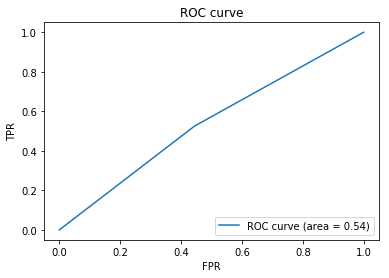

In [60]:
createDT(lomDf, exceptFeatures0, targetVariable)

<b>2.</b> Este teste utiliza o dataframe <b>lomDfX</b> (produto cartesiano dos alunos com os materiais), nenhum tipo de corte e não elimina nenhuma característica redundande.

Before OverSampling, counts of label '1': 410
Before OverSampling, counts of label '0': 4361 

After OverSampling, the shape of train_X: (8722, 75)
After OverSampling, the shape of train_y: (8722,) 

After OverSampling, counts of label '1': 4361
After OverSampling, counts of label '0': 4361
---------

Accuracy: 0.8743276283618582
Balanced Accuracy: 0.550439778692013
MCC:  0.12224927850484177

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93      1920
           1       0.15      0.23      0.18       125

   micro avg       0.87      0.87      0.87      2045
   macro avg       0.55      0.57      0.56      2045
weighted avg       0.90      0.87      0.89      2045

Confusion matrix:
 [[1759   96]
 [ 161   29]]


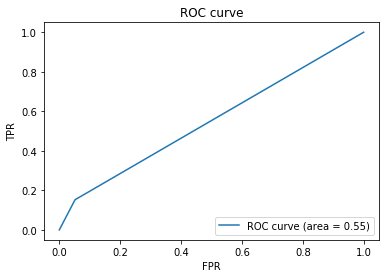


Diretório já existente!


In [61]:
createDT(lomDfX, exceptFeatures0, targetVariable)

<b>3.</b> Este teste utiliza o dataframe <b>lomDf</b>, nenhum tipo de corte e <b>elimina</b> características redundande.

Before OverSampling, counts of label '1': 125
Before OverSampling, counts of label '0': 73 

After OverSampling, the shape of train_X: (250, 18)
After OverSampling, the shape of train_y: (250,) 

After OverSampling, counts of label '1': 125
After OverSampling, counts of label '0': 125
---------

Accuracy: 0.38372093023255816
Balanced Accuracy: 0.32988072818581293
MCC:  -0.3200774998570909

Classification report:
               precision    recall  f1-score   support

           0       0.19      0.14      0.16        36
           1       0.47      0.56      0.51        50

   micro avg       0.38      0.38      0.38        86
   macro avg       0.33      0.35      0.34        86
weighted avg       0.35      0.38      0.37        86

Confusion matrix:
 [[ 5 22]
 [31 28]]


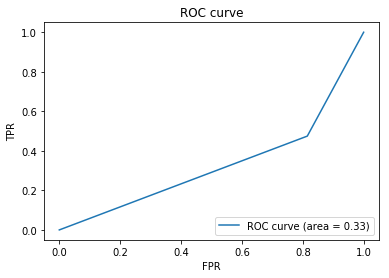


Diretório já existente!


In [62]:
createDT(lomDf, exceptFeatures1, targetVariable)

<b>4.</b> Este teste utiliza o dataframe <b>lomDfX</b>, nenhum tipo de corte e <b>elimina</b> características redundande.

Before OverSampling, counts of label '1': 410
Before OverSampling, counts of label '0': 4361 

After OverSampling, the shape of train_X: (8722, 53)
After OverSampling, the shape of train_y: (8722,) 

After OverSampling, counts of label '1': 4361
After OverSampling, counts of label '0': 4361
---------

Accuracy: 0.8787286063569683
Balanced Accuracy: 0.5859341750602922
MCC:  0.19501695042329592

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93      1901
           1       0.23      0.30      0.26       144

   micro avg       0.88      0.88      0.88      2045
   macro avg       0.59      0.61      0.60      2045
weighted avg       0.89      0.88      0.89      2045

Confusion matrix:
 [[1754  101]
 [ 147   43]]


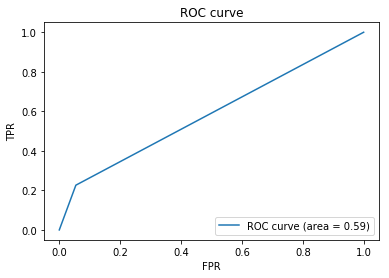


Diretório já existente!


In [63]:
createDT(lomDfX, exceptFeatures1, targetVariable)

<b>Executando os mesmos testes anteriores, porém com poda na árvore:<br>
min_samples_leaf = 10% de 284 ~ 28 </b>

<b>5.</b> Este teste utiliza o dataframe <b>lomDf</b>, poda na árvore e não elimina nenhuma característica redundante.

Before OverSampling, counts of label '1': 125
Before OverSampling, counts of label '0': 73 

After OverSampling, the shape of train_X: (250, 40)
After OverSampling, the shape of train_y: (250,) 

After OverSampling, counts of label '1': 125
After OverSampling, counts of label '0': 125
---------

Accuracy: 0.4069767441860465
Balanced Accuracy: 0.3870056497175141
MCC:  -0.20981842825960775

Classification report:
               precision    recall  f1-score   support

           0       0.33      0.21      0.26        42
           1       0.44      0.59      0.50        44

   micro avg       0.41      0.41      0.41        86
   macro avg       0.39      0.40      0.38        86
weighted avg       0.39      0.41      0.39        86

Confusion matrix:
 [[ 9 18]
 [33 26]]


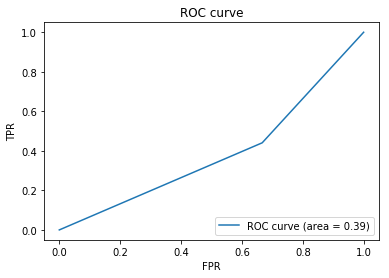


Diretório já existente!


In [64]:
createDT(lomDf, exceptFeatures0, targetVariable, min_samples_leaf=28, max_depth=None)

<b>6.</b> Este teste utiliza o dataframe <b>lomDfX</b>, poda na árvore e não elimina nenhuma característica redundante.

Before OverSampling, counts of label '1': 410
Before OverSampling, counts of label '0': 4361 

After OverSampling, the shape of train_X: (8722, 75)
After OverSampling, the shape of train_y: (8722,) 

After OverSampling, counts of label '1': 4361
After OverSampling, counts of label '0': 4361
---------

Accuracy: 0.8
Balanced Accuracy: 0.556710171655554
MCC:  0.0909783832379703

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      1728
           1       0.26      0.15      0.19       317

   micro avg       0.80      0.80      0.80      2045
   macro avg       0.56      0.54      0.54      2045
weighted avg       0.76      0.80      0.78      2045

Confusion matrix:
 [[1587  268]
 [ 141   49]]


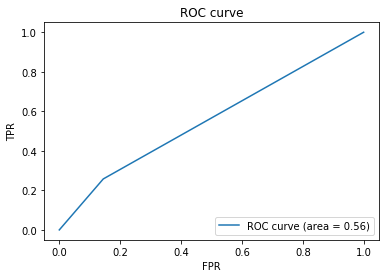


Diretório já existente!


In [65]:
createDT(lomDfX, exceptFeatures0, targetVariable, min_samples_leaf=28, max_depth=None)

<b>7.</b> Este teste utiliza o dataframe <b>lomDf</b>, poda na árvore e <b>elimina</b> características redundantes.

Before OverSampling, counts of label '1': 125
Before OverSampling, counts of label '0': 73 

After OverSampling, the shape of train_X: (250, 18)
After OverSampling, the shape of train_y: (250,) 

After OverSampling, counts of label '1': 125
After OverSampling, counts of label '0': 125
---------

Accuracy: 0.38372093023255816
Balanced Accuracy: 0.3499686126804771
MCC:  -0.27919722485760295

Classification report:
               precision    recall  f1-score   support

           0       0.26      0.17      0.21        40
           1       0.44      0.57      0.50        46

   micro avg       0.38      0.38      0.38        86
   macro avg       0.35      0.37      0.35        86
weighted avg       0.36      0.38      0.36        86

Confusion matrix:
 [[ 7 20]
 [33 26]]


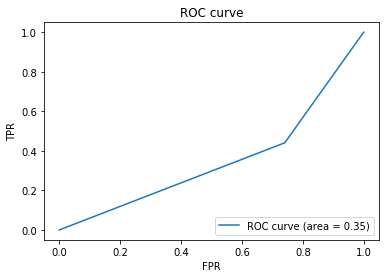


Diretório já existente!


In [66]:
createDT(lomDf, exceptFeatures1, targetVariable, min_samples_leaf=28, max_depth=None)

<b>8.</b> Este teste utiliza o dataframe <b>lomDfX</b>, poda na árvore e <b>elimina</b> características redundantes.

Before OverSampling, counts of label '1': 410
Before OverSampling, counts of label '0': 4361 

After OverSampling, the shape of train_X: (8722, 53)
After OverSampling, the shape of train_y: (8722,) 

After OverSampling, counts of label '1': 4361
After OverSampling, counts of label '0': 4361
---------

Accuracy: 0.8562347188264059
Balanced Accuracy: 0.4979500638388424
MCC:  -0.004949898911476206

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      1919
           1       0.06      0.09      0.07       126

   micro avg       0.86      0.86      0.86      2045
   macro avg       0.50      0.50      0.50      2045
weighted avg       0.88      0.86      0.87      2045

Confusion matrix:
 [[1740  115]
 [ 179   11]]


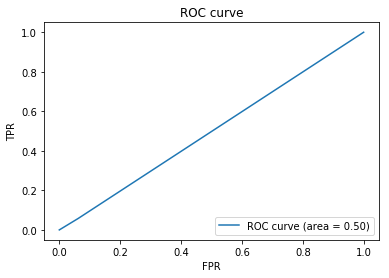


Diretório já existente!


In [67]:
createDT(lomDfX, exceptFeatures1, targetVariable, min_samples_leaf=28, max_depth=None)

O teste que obteve melhor valor de acurácia foi o teste <b>8</b>.


## Random Forest

Accuracy: 0.8855745721271394
Balanced Accuracy: 0.5802596112923819
MCC:  0.19674615228136186

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      1923
           1       0.21      0.32      0.25       122

   micro avg       0.89      0.89      0.89      2045
   macro avg       0.58      0.62      0.59      2045
weighted avg       0.91      0.89      0.90      2045

Confusion matrix:
 [[1772   83]
 [ 151   39]]


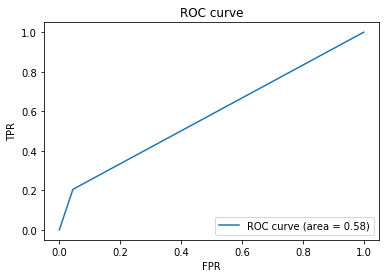

In [68]:
exceptFeatures = ["recommendation", "Processing_neutral_0", 'Perception_neutral_2', 
                  'Representation_neutral_4', 'Understanding_neutral_6', 'InteractivityType.ACTIVE', 
                  'InteractivityType.EXPOSITIVE', 'InteractivityType.MIXED', 
                  'LearningResourceType.EXERCISE', 'LearningResourceType.SIMULATION', 
                  'LearningResourceType.QUESTIONNAIRE', 'LearningResourceType.DIAGRAM', 
                  'LearningResourceType.FIGURE', 'LearningResourceType.GRAPH', 'LearningResourceType.INDEX', 
                  'LearningResourceType.SLIDE', 'LearningResourceType.TABLE', 'LearningResourceType.NARRATIVE_TEXT', 
                  'LearningResourceType.EXAM', 'LearningResourceType.EXPERIMENT', 
                  'LearningResourceType.PROBLEM_STATEMENT', 'LearningResourceType.SELF_ASSESSMENT', 
                  'LearningResourceType.LECTURE', 'InteractivityLevel.VERY_LOW', 'InteractivityLevel.LOW', 
                  'InteractivityLevel.MEDIUM', 'InteractivityLevel.HIGH', 'InteractivityLevel.VERY_HIGH']
targetVariable = "recommendation"

feature_cols = [i for i in lomDfX.columns if i not in exceptFeatures]

X = lomDfX[feature_cols] # Features (independente)
y = lomDfX[[targetVariable]] # Target variable (dependente)
y=y.astype('int')

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Synthetic Minority Oversampling Technique (SMOTE) -> Imbalanced data treatment
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train.values.ravel())

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

balancedAccuracy = metrics.balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balancedAccuracy)

print("MCC: ", metrics.matthews_corrcoef(y_test, y_pred))

report = metrics.classification_report(y_pred, y_test)
print("\nClassification report:\n", report)
    
confMat = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", confMat)

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

plt.clf()
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc="lower right")

feature_imp = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)


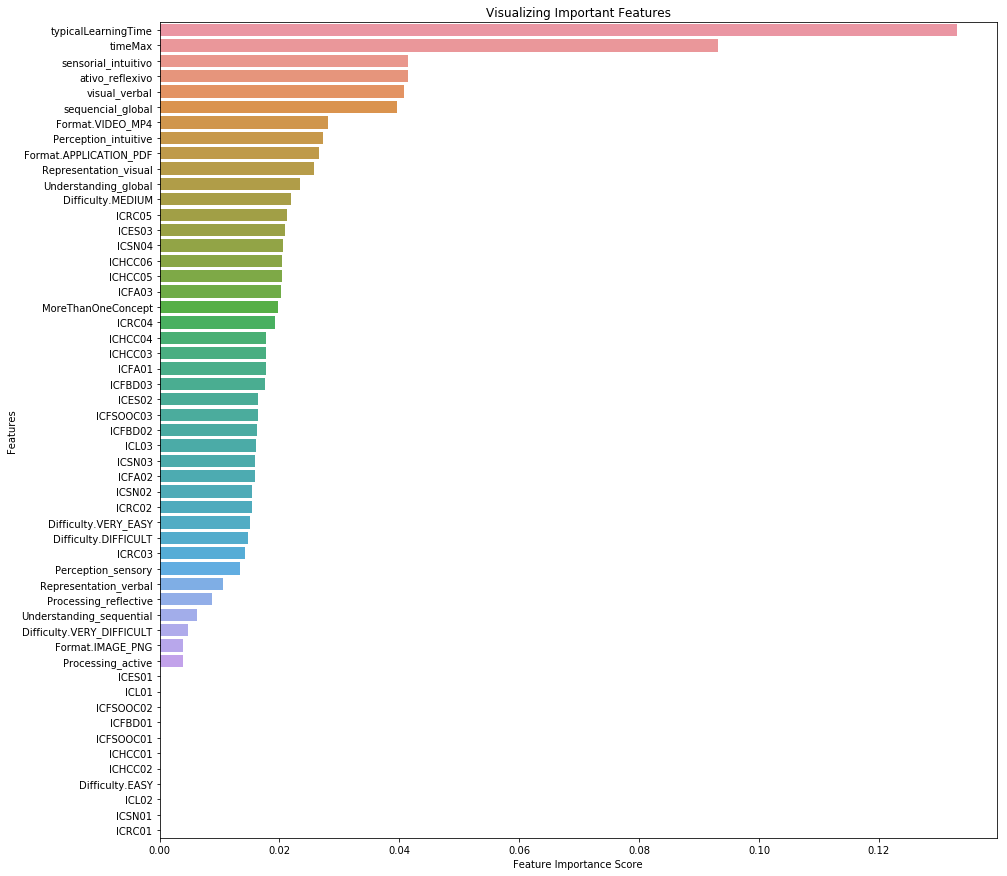

In [69]:
plt.figure(figsize=(15,15))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()


In [70]:
import sklearn
sklearn.__version__

'0.20.3'

## Gradient Boosting Classifier

Accuracy: 0.9051344743276284
Balanced Accuracy: 0.5060079443892751
MCC:  0.05000603844478702

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95      2035
           1       0.02      0.30      0.03        10

   micro avg       0.91      0.91      0.91      2045
   macro avg       0.51      0.60      0.49      2045
weighted avg       0.99      0.91      0.95      2045

Confusion matrix:
 [[1848    7]
 [ 187    3]]


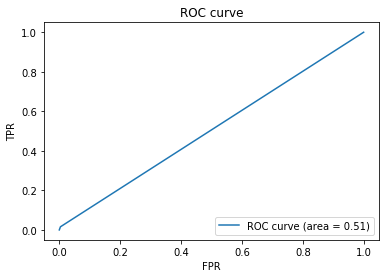

In [71]:
from sklearn.ensemble import GradientBoostingClassifier

exceptFeatures = ["recommendation", "Processing_neutral_0", 'Perception_neutral_2', 
                  'Representation_neutral_4', 'Understanding_neutral_6', 'InteractivityType.ACTIVE', 
                  'InteractivityType.EXPOSITIVE', 'InteractivityType.MIXED', 
                  'LearningResourceType.EXERCISE', 'LearningResourceType.SIMULATION', 
                  'LearningResourceType.QUESTIONNAIRE', 'LearningResourceType.DIAGRAM', 
                  'LearningResourceType.FIGURE', 'LearningResourceType.GRAPH', 'LearningResourceType.INDEX', 
                  'LearningResourceType.SLIDE', 'LearningResourceType.TABLE', 'LearningResourceType.NARRATIVE_TEXT', 
                  'LearningResourceType.EXAM', 'LearningResourceType.EXPERIMENT', 
                  'LearningResourceType.PROBLEM_STATEMENT', 'LearningResourceType.SELF_ASSESSMENT', 
                  'LearningResourceType.LECTURE', 'InteractivityLevel.VERY_LOW', 'InteractivityLevel.LOW', 
                  'InteractivityLevel.MEDIUM', 'InteractivityLevel.HIGH', 'InteractivityLevel.VERY_HIGH']
targetVariable = "recommendation"

feature_cols = [i for i in lomDfX.columns if i not in exceptFeatures]

X = lomDfX[feature_cols] # Features (independente)
y = lomDfX[[targetVariable]] # Target variable (dependente)
y=y.astype('int')

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Synthetic Minority Oversampling Technique (SMOTE) -> Imbalanced data treatment
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train.values.ravel())

clf = GradientBoostingClassifier(random_state=0)

clf.fit(X_train, y_train)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

balancedAccuracy = metrics.balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balancedAccuracy)

print("MCC: ", metrics.matthews_corrcoef(y_test, y_pred))

report = metrics.classification_report(y_pred, y_test)
print("\nClassification report:\n", report)
    
confMat = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", confMat)

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

plt.clf()
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc="lower right")

feature_imp = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)


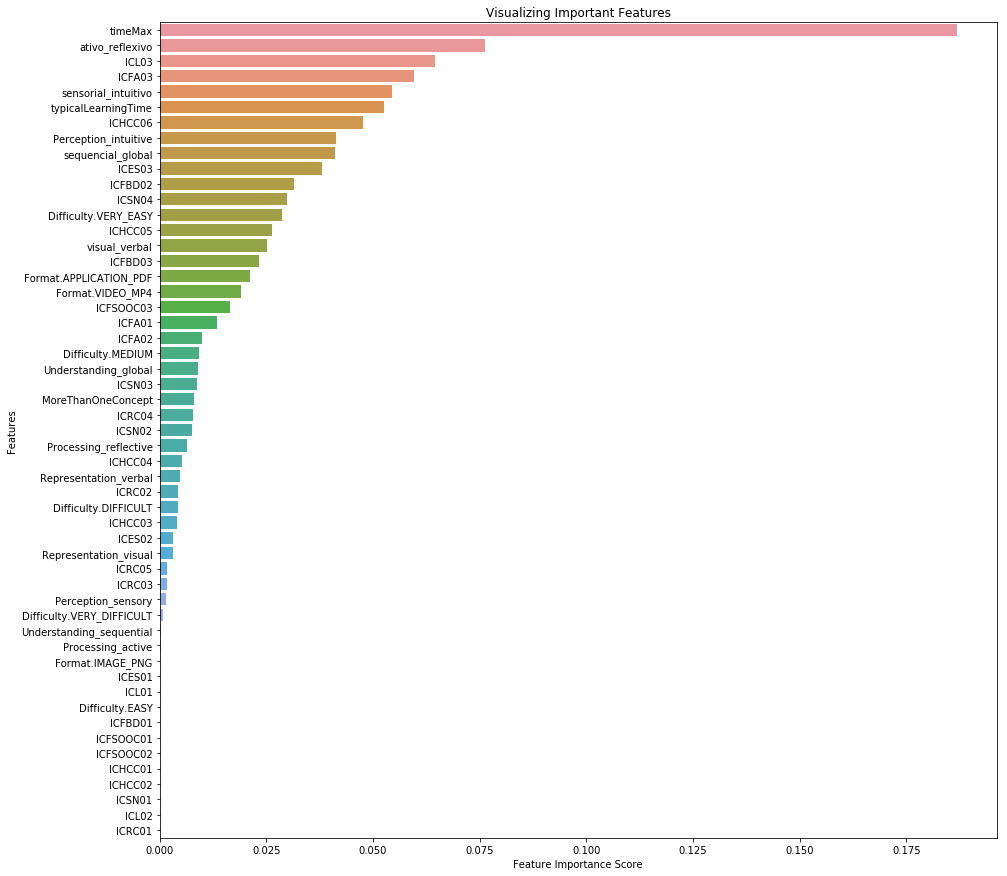

In [72]:
plt.figure(figsize=(15,15))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()